# Healthy vs. IPF G2G Analysis (AT2 --> AT1 healthy trajectory vs. AT2 --> Aberrant Basaloid trajectory)

In [94]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import os,sys,inspect
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 
# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import ClusterUtils
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import pickle
import palantir

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Inline plotting
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

import platform
print(platform.python_version())

3.8.16


In [2]:
adata = anndata.read_h5ad('Kaminski_2020_HLCAlabeltransfer.h5ad')
np.unique(adata.obs.Disease_Identity, return_counts=True)
np.unique(adata.obs.Manuscript_Identity) 
# re annotating HCA obs for  Aberrant_Basaloid as in manuscript identity 
ANNOTATION = []
for i in range(adata.shape[0]):
    if(adata.obs.Manuscript_Identity[i]=='Aberrant_Basaloid'):
        ANNOTATION.append('Aberrant_Basaloid')
    else:
        #ANNOTATION.append(adata.obs.Celltype_HLCA[i])
        ANNOTATION.append(adata.obs.Manuscript_Identity[i])
adata.obs['ANNOTATION'] = ANNOTATION
np.unique(adata.obs.ANNOTATION)
#celltypes_of_interest = ['AT1','AT2','Aberrant_Basaloid', 'Transitional Club-AT2' ]
#adata = adata[[x in celltypes_of_interest for x in adata.obs.ANNOTATION] ] 
np.unique(adata.obs.ANNOTATION, return_counts=True)
np.unique(adata.obs.Manuscript_Identity) 
np.unique(adata.obs.Celltype_HLCA)[52] 
np.unique(adata[adata.obs.Celltype_HLCA =='AT1'].obs.Disease_Identity, return_counts=True)
np.unique(adata[adata.obs.Celltype_HLCA =='AT2'].obs.Disease_Identity, return_counts=True)
np.unique(adata[adata.obs.Manuscript_Identity =='Aberrant_Basaloid'].obs.Disease_Identity, return_counts=True)
np.unique(adata.obs.ANNOTATION)
adata_original = adata.copy()

In [3]:
adata_original.X.data

array([2., 2., 1., ..., 1., 1., 1.], dtype=float32)

# Removing the low quality AT2 cluster 
<-- was a one time run only 

In [ ]:
adata = adata_original.copy()
# removing low quality AT2 cells 
CASE2 = False; celltypes_of_interest = ['ATI','ATII' ] # CASE1 
adata = adata[[x in celltypes_of_interest for x in adata.obs.ANNOTATION] ] 
adata_healthy = adata[adata.obs.Disease_Identity=='Control']
adata_disease = adata[adata.obs.Disease_Identity=='IPF']

# Reset random seed
np.random.seed(5)
temp = adata_disease.copy()
temp = run_palantir_pseudotime(temp)
sc.tl.leiden(temp, key_added='SCVI_leiden')
# IPF data has a strange cluster which accounts for low quality cells (ribo % high) -- so we need to remove it
#sc.pl.embedding(temp[temp.obs.Manuscript_Identity=='ATII'], basis='umap', color=['SCVI_leiden'])
group= [] 
for i in range(temp.shape[0]):
    if(temp.obs.SCVI_leiden[i]=='5'):
        group.append('strange_cluster')
    else:
        group.append('ordinary')
temp.obs['ID'] = group
sc.pl.embedding(temp[temp.obs.Manuscript_Identity=='ATII'], basis='umap', color=['Manuscript_Identity','ID'])
strange_cluster_at2_cells = temp[temp.obs.ID== 'strange_cluster'].obs_names

# mitochondrial genes
temp.var['mt'] = temp.var_names.str.startswith('MT-') 
# ribosomal genes
temp.var['ribo'] = temp.var_names.str.startswith(("RPS","RPL"))
sc.pp.calculate_qc_metrics(temp, qc_vars=['mt','ribo'], percent_top=None, log1p=True, inplace=True)
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_01_qc.html 
mito_genes = temp.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
temp.obs['percent_mt2'] = np.sum(
    temp[:, mito_genes].X, axis=1).A1 / np.sum(temp.X, axis=1).A1

ribo_genes = temp.var_names.str.startswith(("RPS","RPL"))
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
temp.obs['percent_ribo'] = np.sum(
    temp[:, ribo_genes].X, axis=1).A1 / np.sum(temp.X, axis=1).A1
temp.obs['percent_ribo']
sc.pl.embedding(temp, basis='umap', color=['Manuscript_Identity', 'percent_ribo','percent_mt2'])

# Pseudotime estimation using Diffusion Pseudotime 

In [4]:
# found from the above analysis 
strange_cluster_at2_cells = ['021I_CTATTACAGAAGCACC', '021I_CTATTACAGAAGCACT',
       '225I-b_AAAGATGTCCCAGGTG', '225I-b_AAAGTAGCATATACGC',
       '225I-b_AAATGCCCAATAACGA', '225I-b_AACTCAGCACGGTGTC',
       '225I-b_AACTCAGGTCAAACTC', '225I-b_ACACCCTCATGAGCGA',
       '225I-b_ACACTGATCGAGCCCA', '225I-b_ACAGCTAGTTGCGCAC',
       '225I-b_ACCGTAAGTAGCAAAT', '225I-b_ACGGCCATCAGCGACC',
       '225I-b_AGAGTGGGTCCAGTGC', '225I-b_AGCGGTCAGCTAACAA',
       '225I-b_AGCTCCTTCCACGCAG', '225I-b_AGTGGGACACAGTCGC',
       '225I-b_ATGCGATTCTCCAACC', '225I-b_ATGTGTGCATTTGCCC',
       '225I-b_ATTCTACAGGCGCTCT', '225I-b_CACACAAAGGCCCTTG',
       '225I-b_CACACCTCATACTACG', '225I-b_CACCTTGTCATGCAAC',
       '225I-b_CAGCAGCTCTGCCAGG', '225I-b_CAGTCCTCAGCGATCC',
       '225I-b_CATCCACCACGGTAGA', '225I-b_CCCATACCAGCATACT',
       '225I-b_CGCTTCAGTAAAGTCA', '225I-b_CGTTAGATCGGCTTGG',
       '225I-b_CGTTGGGGTCTCCATC', '225I-b_CTACGTCAGGCAGGTT',
       '225I-b_CTCGAAATCGGTTAAC', '225I-b_GACGGCTGTCCAGTTA',
       '225I-b_GATCAGTTCACATGCA', '225I-b_GCACATATCGCGTAGC',
       '225I-b_GCACTCTAGACGCACA', '225I-b_GCAGTTAGTAAGGGAA',
       '225I-b_GCATGATTCACATACG', '225I-b_GGAAAGCGTCTAACGT',
       '225I-b_GTATTCTTCGGCTTGG', '225I-b_GTCACGGAGTGGGTTG',
       '225I-b_GTCACGGCACTCAGGC', '225I-b_GTCATTTGTATTACCG',
       '225I-b_GTCATTTTCAGCATGT', '225I-b_GTCTTCGCACTCGACG',
       '225I-b_GTTCTCGTCGGCCGAT', '225I-b_TAAGAGACATGCAACT',
       '225I-b_TAAGTGCGTGCAGTAG', '225I-b_TACTCATAGCCGCCTA',
       '225I-b_TCAACGAAGGACAGAA', '225I-b_TCATTACGTAGTGAAT',
       '225I-b_TTAACTCAGTATTGGA', '225I-b_TTAGGCATCTTACCGC',
       '225I-b_TTTACTGCAACACGCC', '225I-b_TTTGGTTTCAGGTAAA']

In [5]:
len(strange_cluster_at2_cells)

54

In [6]:
# from literature
AT2_progenitor_markers = ['AXIN2','FGFR2', 'ID2', 'FZD6','LRP5','LRP6'] 
AT1_markers = ['AGER','RTKN2','CLIC5']
Aberrant_markers = ['VIM','MMP7','FN1']

def get_data():

    adata = adata_original.copy()
    print(adata.shape)
    #CASE2 = False; celltypes_of_interest = ['ATI','ATII' ] # CASE1 
    CASE2 = True; celltypes_of_interest = ['ATII','Aberrant_Basaloid','ATI' ] 
    adata = adata[[x in celltypes_of_interest for x in adata.obs.ANNOTATION] ] 

    adata_healthy = adata[adata.obs.Disease_Identity=='Control']
    adata_disease = adata[adata.obs.Disease_Identity=='IPF']
    print(adata_healthy.shape)
    print(adata_disease.shape)
    print(adata_healthy.X.data)
    print(adata_disease.X.data) 
    if(CASE2): 
        adata_disease = adata_disease[ adata_disease.obs.ANNOTATION != 'ATI' ] 
    print(np.unique(adata_healthy.obs.ANNOTATION, return_counts=True)) 
    print(np.unique(adata_disease.obs.ANNOTATION, return_counts=True)) 
    adata_disease = adata_disease[[c not in strange_cluster_at2_cells for c in adata_disease.obs_names] ] 
    
    return adata_healthy, adata_disease

def estimate_dpt_pseudotime(adata_WT,ANNO_COLNAME,ROOT_CELLTYPE ):
    print('====== DPT RUN ====== ')
    sc.pp.normalize_per_cell(adata_WT, 10000) 
    sc.pp.log1p(adata_WT)
    sc.pp.highly_variable_genes(adata_WT, n_top_genes=4000)
    sc.tl.score_genes(adata_WT, gene_list=AT2_progenitor_markers, score_name='dpt_start_score')
    adata_WT.raw = adata_WT.copy()
    adata_WT = adata_WT[:, adata_WT.var.highly_variable]
    sc.pp.neighbors(adata_WT)
    sc.tl.umap(adata_WT)
    sc.tl.leiden(adata_WT, key_added='leiden_normal', resolution=0.1)
    ref_sub = adata_WT.copy()
    sc.tl.diffmap(ref_sub)
    sc.pp.neighbors(ref_sub,use_rep='X_diffmap')
    sc.tl.leiden(ref_sub, key_added='leiden_diffmap', resolution=0.1)
    
    #rootcell = np.argmax(ref_sub.raw[:,'AXIN2'].X )#+ ref_sub.raw[:,'FGFR2'].X + ref_sub.raw[:,'ID2'].X  )
    #root_comp = ref_sub.raw[:,AT2_progenitor_markers[0]].X
    #for marker in AT2_progenitor_markers:
    #    root_comp += ref_sub.raw[:,marker].X
    #rootcell = np.argmax(root_comp)
    rootcell = np.argmax(ref_sub.obs.dpt_start_score)
    
    print(rootcell)
    ref_sub.uns['iroot'] = rootcell
    ref_sub.obs['rootcell'] = 0
    ref_sub.obs['rootcell'][rootcell] = 1
    sc.pl.umap(ref_sub,color='rootcell',color_map='OrRd')
    sc.tl.dpt(ref_sub)
    return ref_sub


def run_palantir_pseudotime(adata, TERMINAL_STATE, ROOT_STATE):
    print('====== PALANTIR RUN ====== ')
    sc.pp.normalize_per_cell(adata, 10000)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=4000)
    sc.tl.score_genes(adata, gene_list=AT2_progenitor_markers, score_name='start_score')
    if(TERMINAL_STATE=='ATI'):
        sc.tl.score_genes(adata, gene_list=AT1_markers, score_name='end_score')
    else:
        sc.tl.score_genes(adata, gene_list=Aberrant_markers, score_name='end_score')

    sc.pp.pca(adata)
    # Run diffusion maps
    pca_projections = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names)
    dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)
    ms_data = palantir.utils.determine_multiscale_space(dm_res)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    adata.layers['MAGIC_imputed_data'] = palantir.utils.run_magic_imputation(adata, dm_res)
    umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names)

    rootcell = np.argmax(adata.obs.start_score)
    terminalcell = np.argmax(adata.obs.end_score)
    
    terminal_states = pd.Series([TERMINAL_STATE], index=[adata.obs_names[terminalcell] ])
    adata.uns['iroot'] = rootcell
    start_cell =  adata.obs_names[rootcell]
    adata.obs['rootcell'] = 0
    adata.obs['rootcell'][start_cell] = 1
    terminal_cell =  adata.obs_names[terminalcell]
    adata.obs['terminalcell'] = 0
    adata.obs['terminalcell'][terminal_cell] = 1
    
    sc.pl.umap(adata,color=['rootcell','terminalcell'],color_map='OrRd')
    
    
    pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, terminal_states=terminal_states.index)
    pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]
    adata.obs['palantir_pseudotime'] = pr_res.pseudotime
    return adata

In [ ]:
adata_healthy, adata_disease = get_data() 
temp_disease = estimate_dpt_pseudotime(adata_disease.copy(), ANNO_COLNAME='ANNOTATION',ROOT_CELLTYPE='ATII')
temp_disease_p = run_palantir_pseudotime(adata_disease.copy(), ROOT_STATE='ATII', TERMINAL_STATE='Aberrant_Basaloid')
adata_disease.obs['dpt_pseudotime'] = temp_disease.obs['dpt_pseudotime']
adata_disease.obsm['X_umap'] = temp_disease.obsm['X_umap']
adata_disease.obsm['X_diffmap'] = temp_disease.obsm['X_diffmap']
adata_disease.obs['leiden_normal'] = temp_disease.obs['leiden_normal']
adata_disease.obs['leiden_diffmap'] = temp_disease.obs['leiden_diffmap']
adata_disease.obs['palantir_pseudotime'] = temp_disease_p.obs['palantir_pseudotime']
adata_disease.obs['palantir_start_score']  = temp_disease_p.obs['start_score']
adata_disease.obs['dpt_start_score']  = temp_disease.obs['dpt_start_score']
adata_disease.obs['palantir_end_score']  = temp_disease_p.obs['end_score']
sc.pl.embedding(adata_disease, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'palantir_pseudotime','leiden_normal','leiden_diffmap', 
                                                   'dpt_start_score' , 'palantir_start_score','palantir_end_score'], legend_loc='on data')

In [ ]:
#adata_healthy, adata_disease = get_data() 
temp_healthy = estimate_dpt_pseudotime(adata_healthy.copy(), ANNO_COLNAME='ANNOTATION',ROOT_CELLTYPE='ATII')
temp_healthy_p = run_palantir_pseudotime(adata_healthy.copy(), ROOT_STATE='ATII', TERMINAL_STATE='ATI')
adata_healthy.obs['dpt_pseudotime'] = temp_healthy.obs['dpt_pseudotime']
adata_healthy.obsm['X_umap'] = temp_healthy.obsm['X_umap']
adata_healthy.obsm['X_diffmap'] = temp_healthy.obsm['X_diffmap']
adata_healthy.obs['leiden_normal'] = temp_healthy.obs['leiden_normal']
adata_healthy.obs['leiden_diffmap'] = temp_healthy.obs['leiden_diffmap']
adata_healthy.obs['palantir_pseudotime'] = temp_healthy_p.obs['palantir_pseudotime']
adata_healthy.obs['palantir_start_score']  = temp_healthy_p.obs['start_score']
adata_healthy.obs['dpt_start_score']  = temp_healthy.obs['dpt_start_score']
adata_healthy.obs['palantir_end_score']  = temp_healthy_p.obs['end_score']
sc.pl.embedding(adata_healthy, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'palantir_pseudotime','leiden_normal','leiden_diffmap', 
                                                   'dpt_start_score' , 'palantir_start_score','palantir_end_score'], legend_loc='on data')

In [11]:
hvgs = [] 
for g in adata_healthy.var_names:
    hvgs.append(g in temp_healthy.var_names)
adata_healthy.var['HVG'] = hvgs 

In [12]:
hvgs = [] 
for g in adata_disease.var_names:
    hvgs.append(g in temp_disease.var_names)
adata_disease.var['HVG'] = hvgs 

In [13]:
common_genes = np.intersect1d(adata_disease.var_names, adata_healthy.var_names )
print(len(common_genes))
print(adata_healthy.shape)
print(adata_disease.shape)
adata_healthy.write_h5ad('adata_healthy_AT2_to_AT1.h5ad')
adata_disease.write_h5ad('adata_IPF_AT2_to_AberrantB.h5ad')

45947
(3157, 45947)
(890, 45947)


# G2G Alignment

In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import os,sys,inspect
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 
# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import ClusterUtils
import VisualUtils
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")

import palantir

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Inline plotting
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

import platform
print(platform.python_version())

adata_healthy = anndata.read_h5ad('adata_healthy_AT2_to_AT1.h5ad')
adata_disease = anndata.read_h5ad('adata_IPF_AT2_to_AberrantB.h5ad')

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


3.8.16


In [2]:
print(adata_healthy.shape)
print(adata_disease.shape)

(3157, 45947)
(890, 45947)


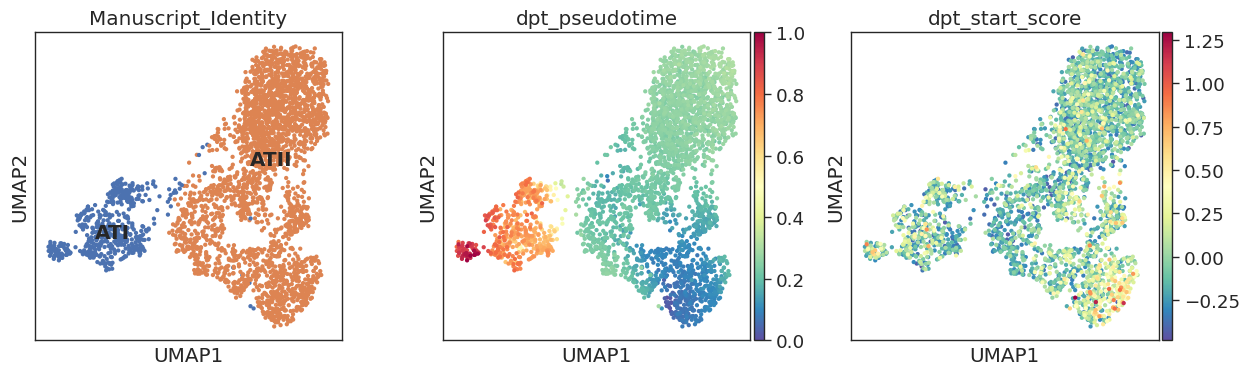

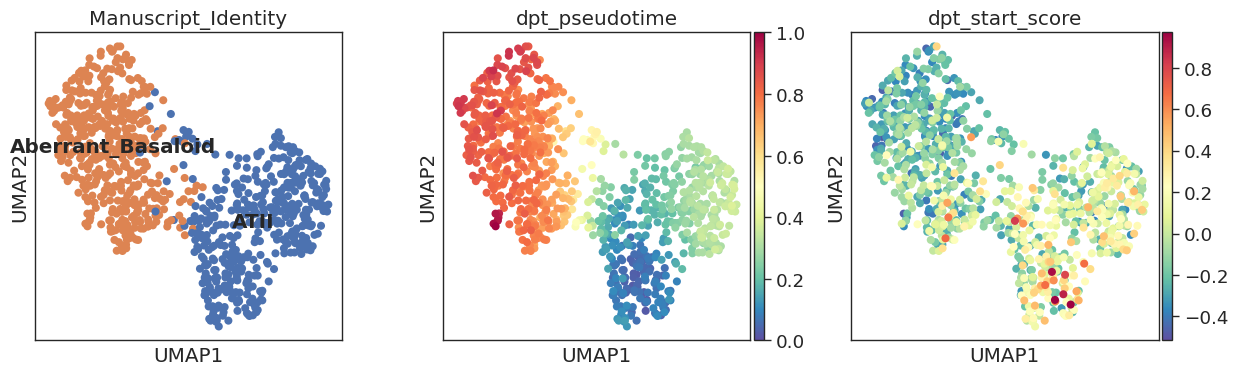

In [3]:
sc.pl.embedding(adata_healthy, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'dpt_start_score' ], legend_loc='on data')
sc.pl.embedding(adata_disease, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'dpt_start_score' ], legend_loc='on data')

In [4]:
vega_20 = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728',
    '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2',
    '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
]
ref_cmap = { 
            'ATII': vega_20[2],
            'ATI':  vega_20[4],
           }
ipf_cmap = { 
            'ATII': vega_20[2],
            'Aberrant_Basaloid':  vega_20[0],
           }

In [5]:
common_hvg_genes = np.intersect1d(adata_healthy.var_names[adata_healthy.var.HVG] , adata_disease.var_names[adata_disease.var.HVG] )
len(common_hvg_genes)

994

0.0 1.0
0.0 1.0


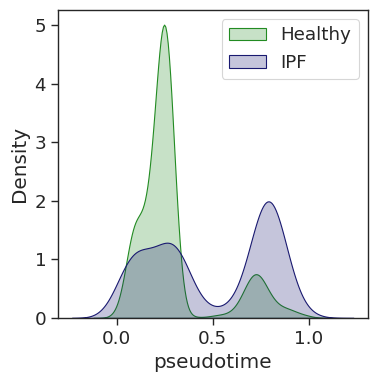

In [6]:
print( np.min(adata_healthy.obs.dpt_pseudotime) , np.max(adata_healthy.obs.dpt_pseudotime) ) 
print( np.min(adata_disease.obs.dpt_pseudotime) , np.max(adata_disease.obs.dpt_pseudotime) ) 
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_healthy.obs['dpt_pseudotime'], fill=True, label='Healthy', color='forestgreen') 
sb.kdeplot(adata_disease.obs['dpt_pseudotime'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()
adata_healthy.obs['time'] = adata_healthy.obs['dpt_pseudotime']
adata_disease.obs['time'] = adata_disease.obs['dpt_pseudotime']
# removing cells with inf pseudotime 
#inf_time_cells = adata_disease[np.where(adata_disease.obs.dpt_pseudotime == np.Inf)[0]].obs_names
#adata_disease = adata_disease[[x not in inf_time_cells for x in adata_disease.obs_names ]] 

In [7]:
def run_G2G_alignment(adata_ref, adata_query, gene_list, n_interpolation_timepoints=15):
    start_t = time.time()
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list,n_interpolation_timepoints)
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.align_all_pairs() 
    end_t = time.time()
    print(end_t-start_t)
    return aligner

In [9]:
adata_ref = adata_healthy
adata_query = adata_disease
print(adata_ref.X.data) 
print(adata_query.X.data)

[1. 1. 4. ... 1. 1. 1.]
[1. 2. 1. ... 1. 1. 1.]


In [10]:
sc.pp.normalize_per_cell(adata_ref, 10000) 
sc.pp.log1p(adata_ref)
sc.pp.normalize_per_cell(adata_query, 10000) 
sc.pp.log1p(adata_query)

In [11]:
print(adata_ref.X.data)
print(adata_query.X.data)

[1.7595813 1.7595813 3.0076618 ... 1.2661365 1.2661365 1.2661365]
[1.1192989 1.6342111 1.1192989 ... 1.284542  1.284542  1.284542 ]


In [11]:
import time
aligner = run_G2G_alignment(adata_ref, adata_query, common_hvg_genes, n_interpolation_timepoints=15)

WINDOW_SIZE= 0.1


100%|██████████| 994/994 [34:39<00:00,  2.09s/it]

2084.9371032714844


In [12]:
pickle.dump(aligner, open('aligner_AT2_to_Abberent_healthy_vs_IPF_26042023.pkl', 'wb')) 

# G2G results analysis

In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import os,sys,inspect
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 
# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import ClusterUtils
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")

import palantir

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Inline plotting
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

import platform
print(platform.python_version())

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


3.8.16


In [7]:
import pickle
with open('aligner_AT2_to_Abberent_healthy_vs_IPF_26042023_with_clusters.pkl', 'rb') as f:
    aligner = pickle.load(f)

Average alignment 5-state string:  IMMMMMMMIIIIIIIDDDDDDDD


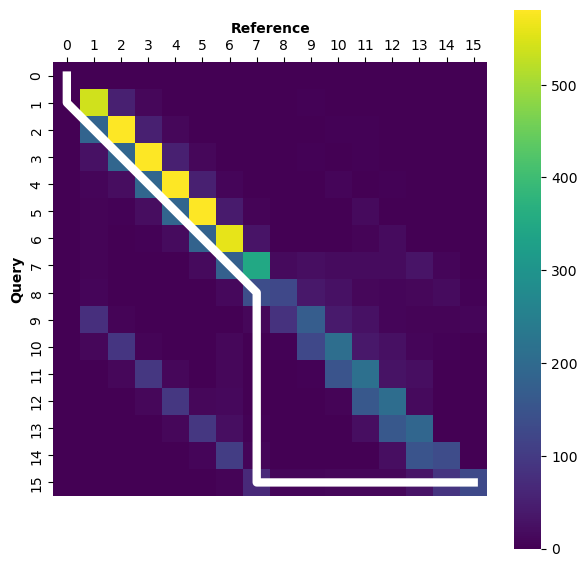

In [128]:
import VisualUtils
vs = VisualUtils.VisualUtils(adata_ref, adata_query, cell_type_colname = 'time', 
                S_len=len(aligner.results[0].S.time_points), 
                T_len=len(aligner.results[0].T.time_points), 
                titleS='Healthy', titleT='Disease',
                write_file=False)

overall_alignment, alignment_path =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_list)
print('Average alignment 5-state string: ', overall_alignment)
mat = aligner.get_pairwise_match_count_mat()
VisualUtils.plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat)
plt.savefig('ms_figs/overall_alignment.png')

run


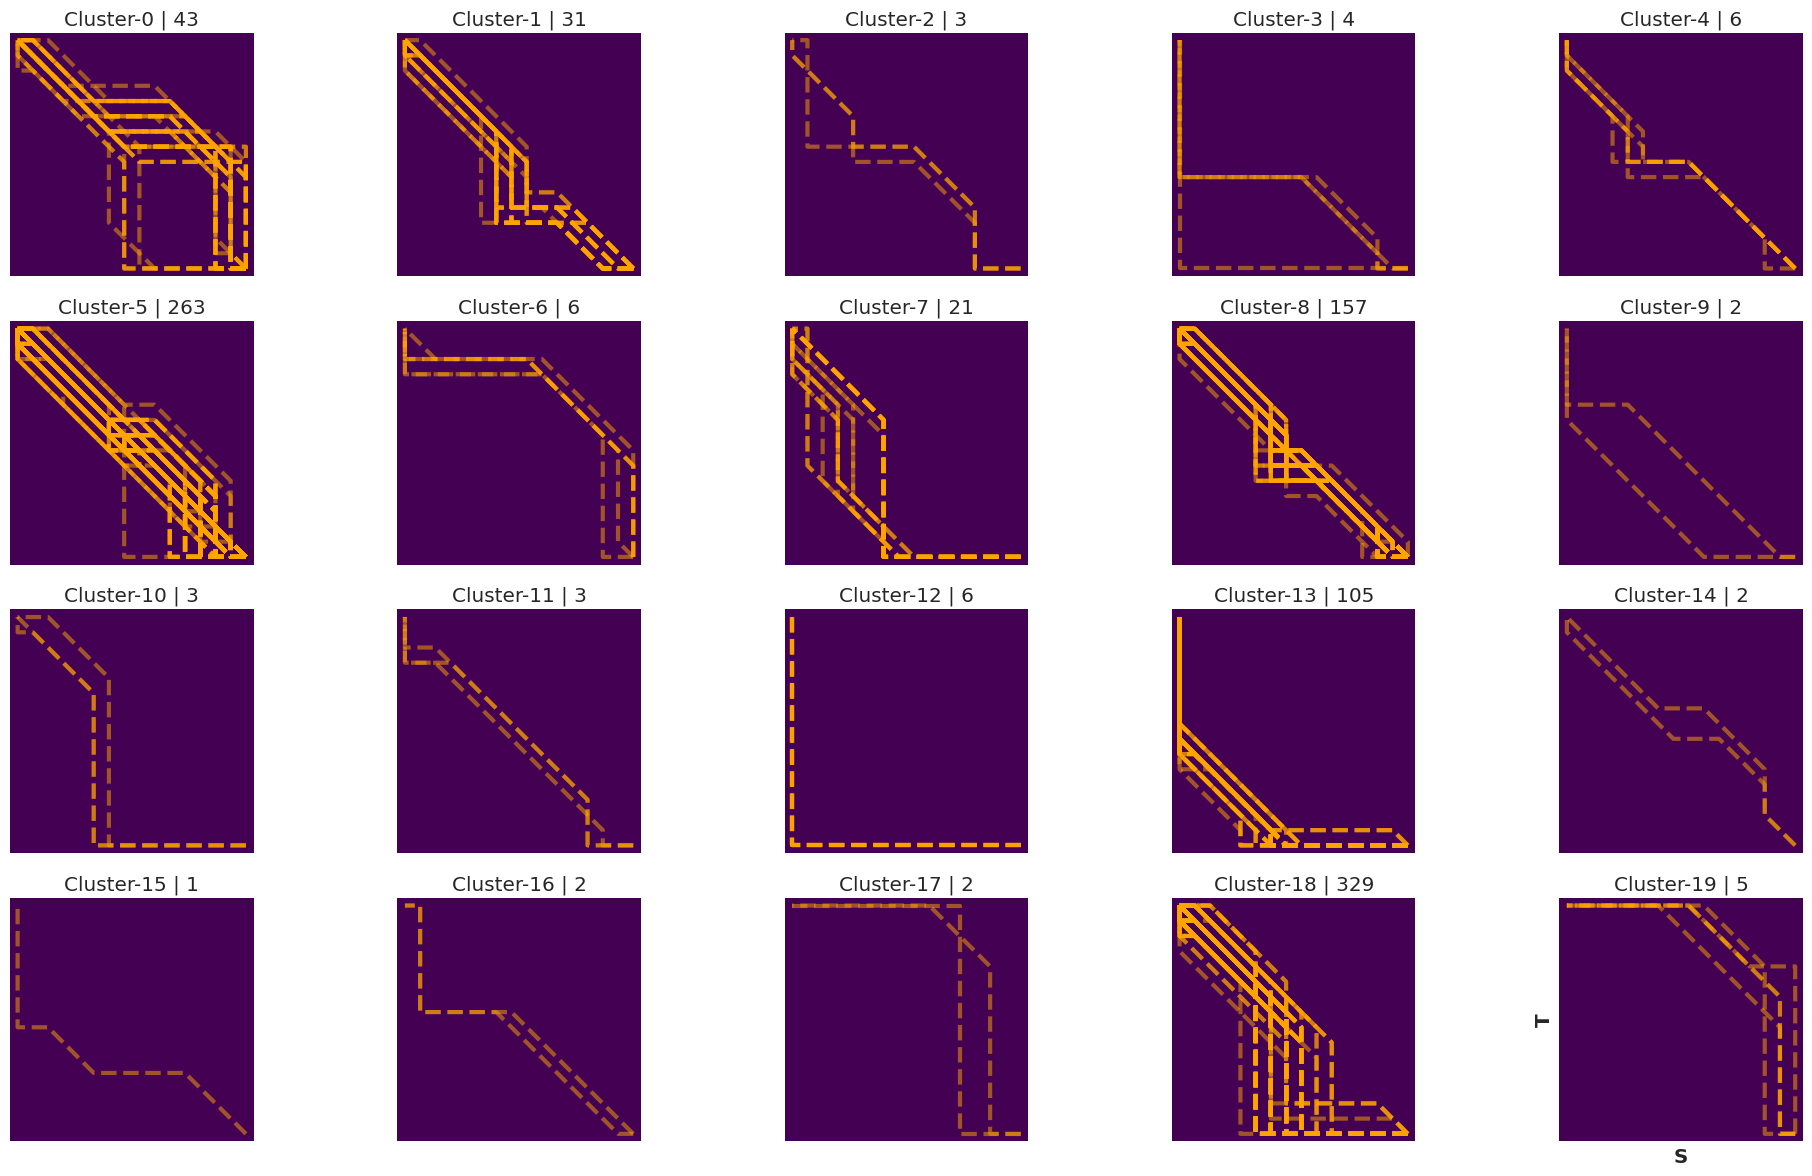

In [71]:
ClusterUtils.run_hierarchical_clustering_with_binary_encode_alignment_path_hamming(aligner, DIST_THRESHOLD=0.25)
plt.savefig('ms_figs/clusters.png')

mean matched percentage:  47.73 %


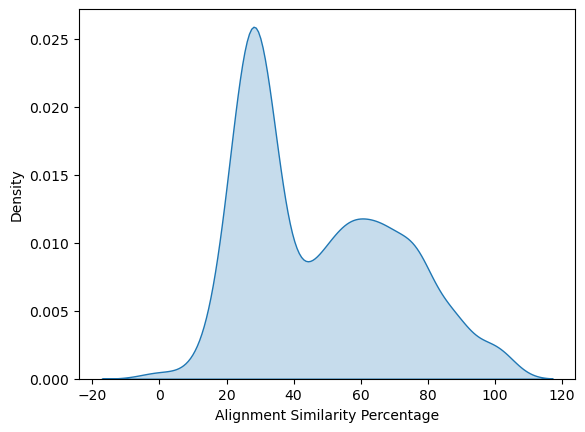

In [18]:
# The overall alignment distribution statistics
import matplotlib as mpl
mpl.style.use('default')
df = aligner.get_match_stat_for_all_genes() 
print('mean matched percentage: ', round(np.mean(df['match %']),2),'%' )
#print('mean matched percentage wrt ref: ',round(np.mean(df['match % S']),2),'%'  )
#print('mean matched percentage wrt query: ', round(np.mean(df['match % T']),2),'%' )
#sb.kdeplot(df['match % S'], fill=True, label='match % Reference')
#sb.kdeplot(df['match % T'], fill=True,label='match % Query')
sb.kdeplot(df['match %'], fill=True,label='Alignment Similarity %')
#plt.legend()
plt.xlabel('Alignment Similarity Percentage')
plt.savefig('ms_figs/alignment_dist.png')

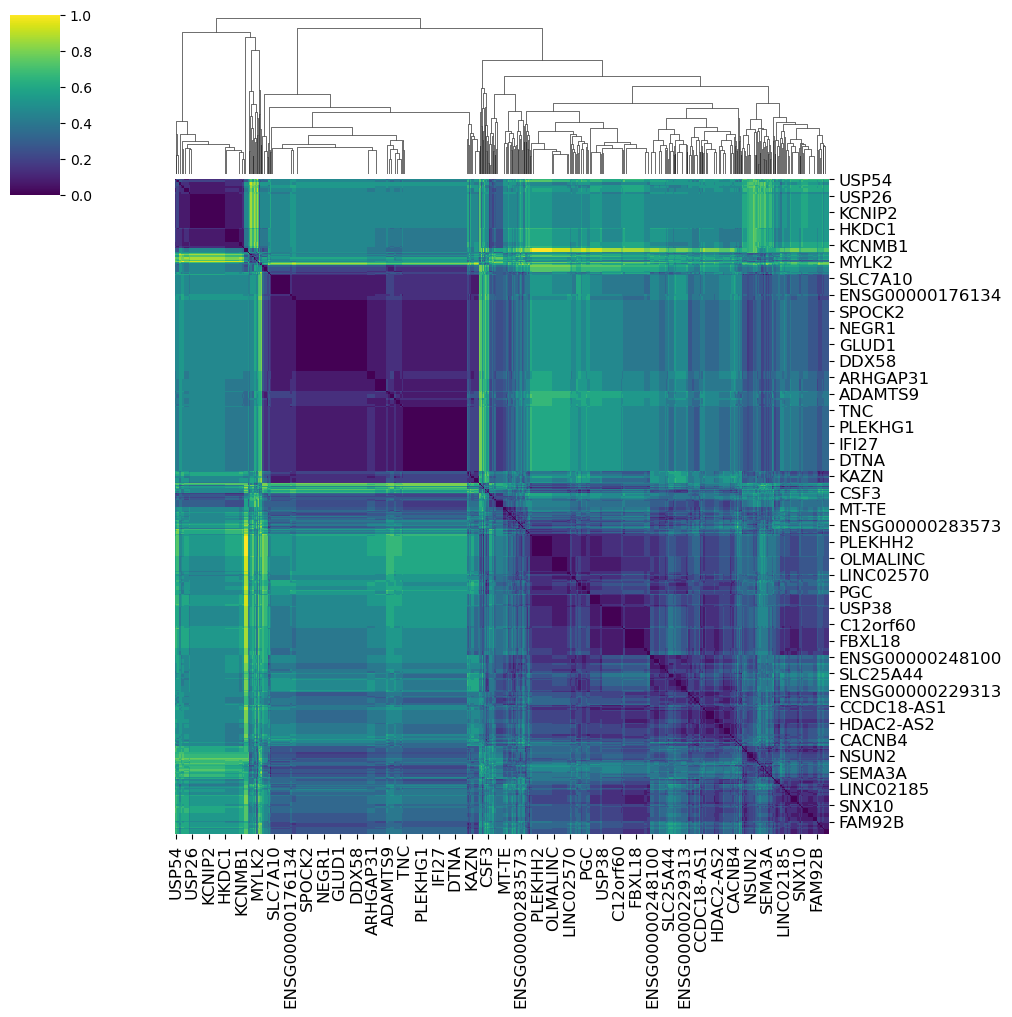

In [129]:
#ClusterUtils.run_hierarchical_clustering_with_binary_encode_alignment_path_hamming(aligner, DIST_THRESHOLD=0.25)
p = sb.clustermap(aligner.DistMat,cmap='viridis', figsize=(10,10))
p.ax_heatmap.set_xticklabels(p.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
p.ax_heatmap.set_yticklabels(p.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
p.ax_row_dendrogram.set_visible(False)

In [72]:
# Clusters do not necessarily output similar gene programs 
# If one pathway is overrepresented in several clusters, that means the particular pathway has several gene subsets which match/mismatch differently along pseudotime. 
# Such clusters reveal pathways with varying alignment patterns
# A cluster might not have any significant overepresentation result as well
import PathwayAnalyserV2
PathwayAnalyserV2.run_cluster_overrepresentation_analysis(aligner)

100%|██████████| 20/20 [00:56<00:00,  2.81s/it]

+----+--------------+-----------+--------------------------------+------------------------------------------+------------------------------------------+------------+
|    |   cluster_id |   n_genes | Cluster genes                  | Pathways                                 | Pathway genes                            | Source     |
+====+==============+===========+================================+==========================================+==========================================+============+
|  0 |            2 |         3 | ['CXCL3', 'MT1X', 'MT2A']      | ['Mineral absorption', 'Rheumatoid       | ['MT2A;MT1X', 'CXCL3', 'CXCL3', 'CXCL3', | ['KEGG',   |
|    |              |           |                                | arthritis', 'TNF signaling pathway',     | 'CXCL3', 'CXCL3', 'CXCL3', 'CXCL3',      | 'KEGG',    |
|    |              |           |                                | 'NF-kappa B signaling pathway',          | 'CXCL3', 'MT2A', 'CXCL3', 'MT2A',        | 'KEGG',    |
|   

In [73]:
import gseapy as gp

def run_overrepresentation_analysis(gene_set, TARGET_GENESETS=['MSigDB_Hallmark_2020','KEGG_2021_Human']):
    enr = gp.enrichr(gene_list=gene_set,
                     gene_sets=TARGET_GENESETS,
                     organism='human',
                     outdir=None,
                    )
    return enr
    df = enr.results[enr.results['Adjusted P-value']<0.05]
    if(df.shape[0]==0):
        return df
    df = df.sort_values('Adjusted P-value')
    df['-log10 Adjusted P-value'] = [-np.log10(q) for q in df['Adjusted P-value']]
    max_q = max(df['-log10 Adjusted P-value'][df['-log10 Adjusted P-value']!=np.inf])
    #df.columns = ['Gene_set']+list(df.columns[1:len(df.columns)])
    qvals = []
    for q in df['-log10 Adjusted P-value']:
        if(q==np.inf):
            q = -np.log10(0.00000000001) # NOTE: For -log10(p=0.0) we replace p with a very small p-val to avoid inf
        qvals.append(q)
    df['-log10 FDR q-val'] = qvals 
    df = df.sort_values('Adjusted P-value',ascending=True)
    return df

enr = run_overrepresentation_analysis(aligner.gene_clusters[13])
enr.results

Gene_set                                     Term Overlap  \
0    MSigDB_Hallmark_2020            TNF-alpha Signaling via NF-kB   3/200   
1    MSigDB_Hallmark_2020                               Complement   3/200   
2    MSigDB_Hallmark_2020                        Androgen Response   2/100   
3    MSigDB_Hallmark_2020                           Myc Targets V2    1/58   
4    MSigDB_Hallmark_2020        Epithelial Mesenchymal Transition   2/200   
..                    ...                                      ...     ...   
98        KEGG_2021_Human                   MAPK signaling pathway   1/294   
99        KEGG_2021_Human  Neuroactive ligand-receptor interaction   1/341   
100       KEGG_2021_Human               PI3K-Akt signaling pathway   1/354   
101       KEGG_2021_Human                        Alzheimer disease   1/369   
102       KEGG_2021_Human            Pathways of neurodegeneration   1/475   

      P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0    0.088312          0.652868            0                     0   
1    0.088312          0.652868            0                     0   
2    0.097112          0.652868            0                     0   
3    0.263421          0.652868            0                     0   
4    0.282755          0.652868            0                     0   
..        ...               ...          ...                   ...   
98   0.789662          0.830683            0                     0   
99   0.836417          0.868586            0                     0   
100  0.847421          0.868875            0                     0   
101  0.859210          0.869950            0                     0   
102  0.920380          0.920380            0                     0   

     Odds Ratio  Combined Score               Genes  
0      2.940878        7.137142  TNFAIP8;KYNU;CXCL1  
1      2.940878        7.137142   KCNIP2;KYNU;CXCL1  
2      3.922528        9.146885       TNFAIP8;FKBP5  
3      3.346491        4.464228               WDR74  
4      1.931647        2.440009         CXCL8;CXCL1  
..          ...             ...                 ...  
98     0.643279        0.151911               FGF18  
99     0.553026        0.098786              CHRNA7  
100    0.532306        0.088127               FGF18  
101    0.510216        0.077421              CHRNA7  
102    0.393967        0.032687              CHRNA7  

[103 rows x 10 columns]

In [69]:
enr.res2d.sort_values('Adjusted P-value')[0:20]

Gene_set                                               Term  \
0   KEGG_2021_Human                            IL-17 signaling pathway   
1   KEGG_2021_Human  Viral protein interaction with cytokine and cy...   
2   KEGG_2021_Human                               Rheumatoid arthritis   
3   KEGG_2021_Human    Neomycin, kanamycin and gentamicin biosynthesis   
4   KEGG_2021_Human                            Sphingolipid metabolism   
5   KEGG_2021_Human                                            Malaria   
6   KEGG_2021_Human                                      Legionellosis   
7   KEGG_2021_Human  Epithelial cell signaling in Helicobacter pylo...   
8   KEGG_2021_Human                                          Pertussis   
9   KEGG_2021_Human             Cytokine-cytokine receptor interaction   
10  KEGG_2021_Human                NOD-like receptor signaling pathway   
11  KEGG_2021_Human                        Chemokine signaling pathway   
13  KEGG_2021_Human                       NF-kappa B signaling pathway   
12  KEGG_2021_Human                                         Amoebiasis   
14  KEGG_2021_Human                              TNF signaling pathway   
15  KEGG_2021_Human                              Glutamatergic synapse   
16  KEGG_2021_Human                            Chemical carcinogenesis   
29  KEGG_2021_Human    Kaposi sarcoma-associated herpesvirus infection   
38  KEGG_2021_Human                              p53 signaling pathway   
37  KEGG_2021_Human                   Regulation of actin cytoskeleton   

   Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0     4/94  0.001523          0.077410            0                     0   
1    4/100  0.001911          0.077410            0                     0   
2     3/93  0.012968          0.350135            0                     0   
3      1/5  0.025978          0.383374            0                     0   
4     2/49  0.027354          0.383374            0                     0   
5     2/50  0.028398          0.383374            0                     0   
6     2/57  0.036136          0.418149            0                     0   
7     2/70  0.052347          0.515903            0                     0   
8     2/76  0.060550          0.515903            0                     0   
9    4/295  0.069983          0.515903            0                     0   
10   3/181  0.070061          0.515903            0                     0   
11   3/192  0.080400          0.542701            0                     0   
13   2/104  0.103700          0.599980            0                     0   
12   2/102  0.100391          0.599980            0                     0   
14   2/112  0.117225          0.610909            0                     0   
15   2/114  0.120673          0.610909            0                     0   
16   3/239  0.131136          0.624824            0                     0   
29   2/193  0.269138          0.663614            0                     0   
38    1/73  0.319518          0.663614            0                     0   
37   2/218  0.317641          0.663614            0                     0   

    Odds Ratio  Combined Score                        Genes  
0     8.715072       56.538009     CXCL8;CXCL1;DEFB4A;CXCL5  
1     8.167904       51.130623  CXCL8;CXCL1;CXCL5;TNFRSF10D  
2     6.472222       28.123575            CXCL8;CXCL1;CXCL5  
3    47.814904      174.548160                        HKDC1  
4     8.199959       29.510689                   GALC;SGPP2  
5     8.028722       28.593771                  CXCL8;ACKR1  
6     7.004413       23.257851                  CXCL8;CXCL1  
7     5.661622       16.701033                  CXCL8;CXCL1  
8     5.200997       14.585121                  CXCL8;CXCL5  
9     2.668028        7.095640  CXCL8;CXCL1;CXCL5;TNFRSF10D  
10    3.257931        8.660852           CXCL8;CXCL1;DEFB4A  
11    3.066604        7.730108            CXCL8;CXCL1;CXCL5  
13    3.767942        8.539099  

In [167]:
pickle.dump(aligner, open('aligner_AT2_to_Abberent_healthy_vs_IPF_26042023_with_clusters.pkl', 'wb')) 

KRT17 DDMMMIIIIIIIIIIIIDDDDDDDDDD
MMP7 DMMMMMIIIIIIIIIIDDDDDDDDD
COL6A2 DMMMMIIIIIIIIIIIDDDDDDDDDD


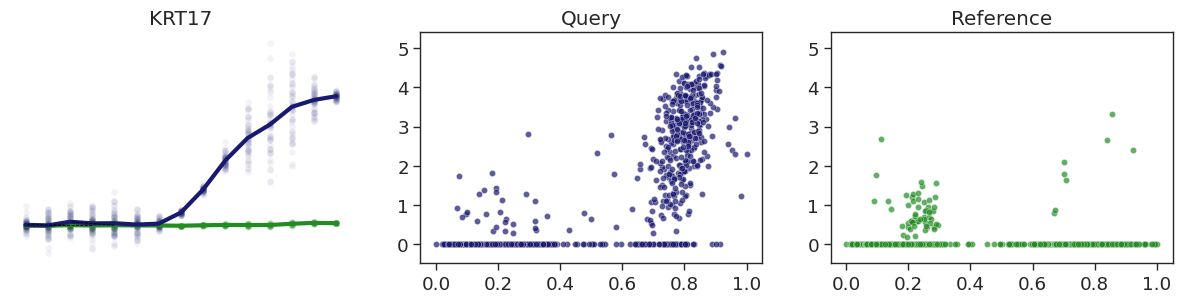

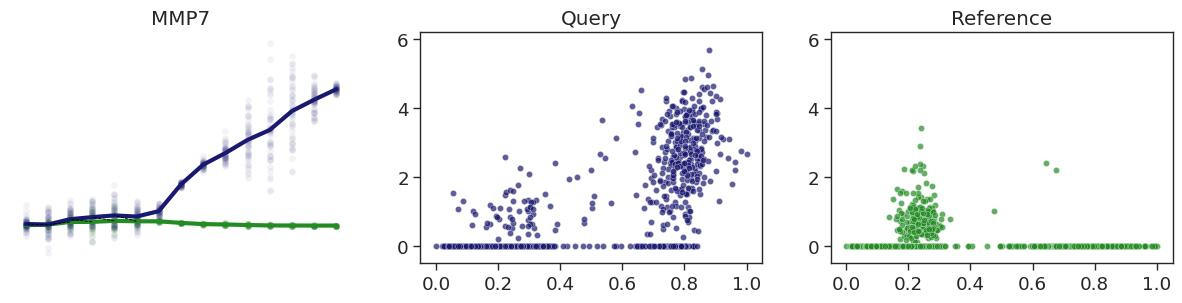

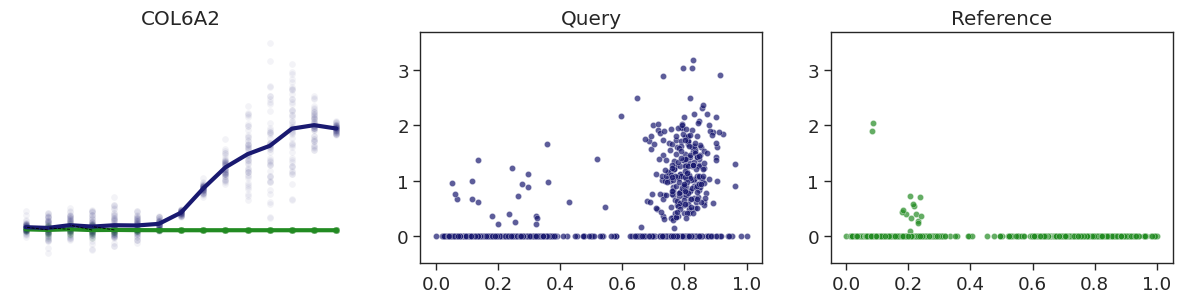

In [154]:
for g in ['KRT17','MMP7', 'COL6A2']: 
    VisualUtils.plotTimeSeries(aligner.results_map[g], aligner, plot_cells=True) 
    print(g,aligner.results_map[g].alignment_str) 
    #plt.savefig('ms_figs/sup/'+g+'.png')

In [62]:
for i in range(len(aligner.gene_clusters)):
        average_alignment, avg_path =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[i] ) # pink 
        print('cluster: ', i, average_alignment)

cluster:  0 MMMMMMDDDDWWMMIIIIIIID
cluster:  1 IMMMMMMMIIIDDDMMMMD
cluster:  2 IIMMMMIDDDDMMVMMMIIDD
cluster:  3 IIIIIIIIIDDDDDDDDDVMMMMMD
cluster:  4 IMMMMMMIDDMMMMMMM
cluster:  5 IMMMMMMMIDMMMMMIDD
cluster:  6 IMMMDDDDDDMMMMMIIIIIDI
cluster:  7 IMMMMMMIIIVVVVIDDDDDDDDD
cluster:  8 IMMMMMMIDIDMMMMMMD
cluster:  9 IIIIMDDMMWMMMMMMMMW
cluster:  10 IIDMMMMIIIIIIMDDDDDMMWW
cluster:  11 IIMDMDMMMMMMMMIMMD
cluster:  12 IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD
cluster:  13 IIIIIIIIMMMMMMMDDDDDDDD
cluster:  14 MMMMMMMDMMMMMIMM
cluster:  15 IIIIIDDDMMMMDDDMMVMMM
cluster:  16 IIMDDDDMVVMMMMMMMMM
cluster:  17 IIDMMMMMDDMVMMVMMVDD
cluster:  18 IMMMMMMIDIIIIIIIDDDDDDDD
cluster:  19 DDDDDDDDMIMMMMIMIIIIIIID


FN1 DMMMMIIIIIIIIIIIDDDDDDDDDD


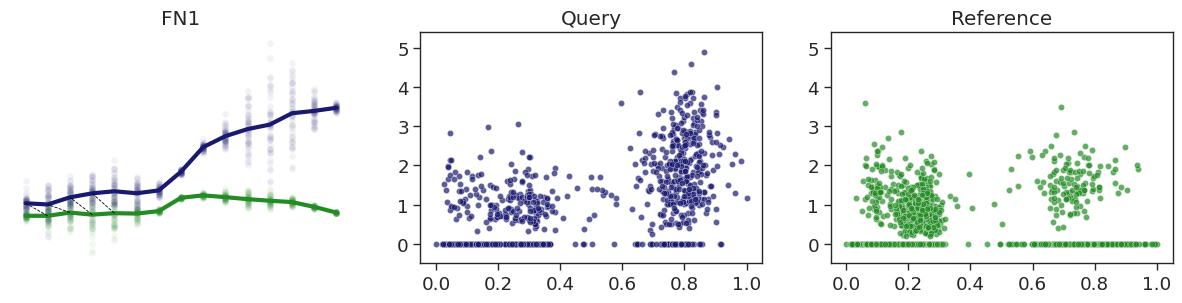

In [156]:
for g in ['FN1']: 
    VisualUtils.plotTimeSeries(aligner.results_map[g], aligner, plot_cells=True) 
    print(g,aligner.results_map[g].alignment_str) 
    plt.savefig('ms_figs/sup/'+g+'.png')

In [126]:
for i in range(len(aligner.gene_clusters)):
    if(len(aligner.gene_clusters[i])<=40):
        print('Cluster-', i, aligner.gene_clusters[i])

Cluster- 1 ['ACOT13', 'ACSL4', 'ADAMTS9-AS2', 'ADAMTSL1', 'ADGRA2', 'C1orf87', 'ENSG00000115934', 'ENSG00000227307', 'ENSG00000230105', 'ENSG00000238045', 'ENSG00000248738', 'ENSG00000255118', 'ENSG00000256690', 'ENSG00000273727', 'ENSG00000274428', 'ENSG00000282143', 'ENSG00000283573', 'GMEB1', 'HFE', 'IGHA2', 'LPIN2', 'MMRN1', 'MT-TE', 'MT-TV', 'PDK4', 'PLOD2', 'SLC10A1', 'SLC5A9', 'SYTL3', 'TBC1D4', 'ZNF610']
Cluster- 2 ['CXCL3', 'MT1X', 'MT2A']
Cluster- 3 ['BCYRN1', 'ENSG00000266978', 'LRRK2', 'SLC7A11']
Cluster- 4 ['CSF3', 'ENSG00000224700', 'ENSG00000255237', 'HP', 'ORM1', 'SFTPA1']
Cluster- 6 ['ATP8B5P', 'BBOX1-AS1', 'ENSG00000251138', 'ENSG00000263574', 'MARCH3', 'MT1G']
Cluster- 7 ['ABTB2', 'ANKRD20A21P', 'AQP5', 'ARMH1', 'C12orf40', 'CCDC200', 'CRIM1', 'ENSG00000231079', 'ENSG00000253361', 'ENSG00000254143', 'GPC5', 'HIST1H2BJ', 'HMGCS1', 'LINC-PINT', 'LRRIQ4', 'PNP', 'PSAT1', 'RHOXF1-AS1', 'S100A4', 'TFCP2L1', 'TXNDC11']
Cluster- 9 ['ENSG00000259011', 'LINC01862']
Cluster- 1

In [173]:
avail_genes = common_hvg_genes

# Let's pick the pathways of interest from the above list and check their alignment statistics
from gsea_api.molecular_signatures_db import MolecularSignaturesDatabase
from adjustText import adjust_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import zscore


def plot_alignment_path_on_given_matrix(mat, paths, cmap='viridis'):

        fig,ax = plt.subplots(1,1, figsize=(7,7))
        sb.heatmap(mat, square=True,  cmap='viridis', ax=ax, cbar=True,xticklabels=True, yticklabels=True)  
        for path in paths: 
            path_x = [p[0]+0.5 for p in path]
            path_y = [p[1]+0.5 for p in path]
            ax.plot(path_y, path_x, color='white', linewidth=6)
        plt.xlabel("Reference pseudotime",fontweight='bold')
        plt.ylabel("Organoid pseudotime",fontweight='bold')
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')        
        
def get_pathway_alignment_stat(aligner, pathway_name, cluster=False):
    
    print('PATHWAY ======= ',pathway_name)
    GENE_LIST = IGS.SETS[pathway_name]
    perct_A = []
    perct_S = []
    perct_T = []
    for gene in GENE_LIST:
        series_match_percent = aligner.results_map[gene].get_series_match_percentage()
        perct_A.append(series_match_percent[0])
        perct_S.append(series_match_percent[1])
        perct_T.append(series_match_percent[2])

    print('mean matched percentage: ', round(np.mean(perct_A),2),'%' )
    print('mean matched percentage wrt ref: ',round(np.mean(perct_S),2),'%'  )
    print('mean matched percentage wrt query: ', round(np.mean(perct_T),2),'%' )
    plt.subplots(1,1,figsize=(2,2))

    # average matched percentage by alignment cluster
    sb.kdeplot(perct_S, fill=True, label='match % S')
    sb.kdeplot(perct_T, fill=True,label='match % T')
    sb.kdeplot(perct_A, fill=True,label='match %')
    plt.title(pathway_name)
    plt.legend()
    average_alignment, alignment_path =  ClusterUtils.get_cluster_average_alignments(aligner, GENE_LIST)
    mat = ClusterUtils.get_pairwise_match_count_mat(aligner,GENE_LIST )
    print('Average Alignment: ', average_alignment)
    plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat)


    plt.xlabel('Healthy pseudotime')
    plt.ylabel('IPF pseudotime')
    plt.savefig('Healthy_vs_IPF_'+pathway_name+'_overall_alignment.png')
    plot_mean_trend_heatmaps(pathway_name,cluster=cluster) 

def plot_DE_genes(pathway_name):
    PATHWAY_SET = IGS.SETS[pathway]
    ax=sb.scatterplot(x['l2fc'],x['sim']*100,s=50, legend=False, hue =x['sim'] ,palette=sb.diverging_palette(15, 133, s=50, as_cmap=True),edgecolor='k',linewidth=0.3)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.ylabel('Alignment Similarity %', fontsize=12, fontweight='bold')
    plt.xlabel('L2FC mean expression', fontsize = 12, fontweight='bold')
    plt.grid(False)
    plt.tight_layout()

    TEXTS = [] 
    for label, a, b in zip(x.index, x['l2fc'],x['sim']*100):
        if(label in PATHWAY_SET):# and b<=50):
            TEXTS.append(ax.text(a, b, label, color='white', fontsize=9, fontweight='bold',bbox=dict(boxstyle='round,pad=0.1', fc='black', alpha=0.75)))
    adjust_text(TEXTS, expand_points=(2, 2),arrowprops=dict(arrowstyle="->", color='black', lw=2))
    plt.title(pathway_name,fontweight='bold', fontsize=15)
    
    
def plot_heatmaps(mat_ref,mat_query,pathway_name, cluster=False):
    
    if(cluster):
        g=sb.clustermap(mat_ref, figsize=(0.4,0.4), col_cluster=False) 
        gene_order = g.dendrogram_row.reordered_ind
        df = pd.DataFrame(g.data2d) 
        df.index = IGS.SETS[pathway_name][gene_order]
    else:
        df=mat_ref
    
    plt.subplots(1,2,figsize=(8,27)) #8,14/7
    max_val = np.max([np.max(mat_ref),np.max(mat_query)]) 
    min_val = np.min([np.min(mat_ref),np.min(mat_query)]) 
    plt.subplot(1,2,1)
    ax=sb.heatmap(df, vmax=max_val,vmin=min_val, cbar_kws = dict(use_gridspec=False,location="top")) 
    plt.title('Healthy')
    ax.yaxis.set_label_position("left")
    for tick in ax.get_yticklabels():
        tick.set_rotation(360)
    plt.subplot(1,2,2)
    if(cluster):
        mat_query = mat_query.loc[IGS.SETS[pathway_name][gene_order]] 
    ax = sb.heatmap(mat_query,vmax=max_val,  vmin=min_val,cbar_kws = dict(use_gridspec=False,location="top"), yticklabels=False) 
    plt.title('IPF')
    plt.savefig(pathway_name+'_heatmap.pdf', bbox_inches='tight')
    plt.show()
    
    
# smoothened/interpolated mean trends + Z normalisation 
def plot_mean_trend_heatmaps(pathway_name, cluster=False):
    S_mat = []
    T_mat = []
    S_zmat = []
    T_zmat = []

    for gene in IGS.SETS[pathway_name]:

        fS = pd.DataFrame([aligner.results_map[gene].S.mean_trend, np.repeat('Healthy', len(aligner.results_map[gene].S.mean_trend))]).transpose()
        fT = pd.DataFrame([aligner.results_map[gene].T.mean_trend, np.repeat('IPF', len(aligner.results_map[gene].T.mean_trend))]).transpose()
        f = pd.concat([fS,fT])
        f[0] = np.asarray(f[0], dtype=np.float64)
        from scipy.stats import zscore
        f['z_normalised'] = zscore(f[0])
        S_mat.append(np.asarray(f[f[1]=='Healthy'][0]))
        T_mat.append(np.asarray(f[f[1]=='IPF'][0]))    
        S_zmat.append(np.asarray(f[f[1]=='Healthy']['z_normalised']))
        T_zmat.append(np.asarray(f[f[1]=='IPF']['z_normalised']))  
    S_mat = pd.DataFrame(S_mat)
    T_mat = pd.DataFrame(T_mat)
    S_zmat = pd.DataFrame(S_zmat)
    T_zmat = pd.DataFrame(T_zmat)
    
    S_mat.index = IGS.SETS[pathway_name]
    T_mat.index = IGS.SETS[pathway_name]
    S_zmat.index = IGS.SETS[pathway_name]
    T_zmat.index = IGS.SETS[pathway_name]
    
   # print('Interpolated mean trends')
   # plot_heatmaps(S_mat, T_mat, pathway_name, cluster=cluster)
    print('Z-normalised Interpolated mean trends')
    plot_heatmaps(S_zmat, T_zmat, pathway_name,cluster=cluster)
    


class InterestingGeneSets:
    
    def __init__(self):        
        self.SETS = {}
        self.dbs = {}
        self.msigdb = MolecularSignaturesDatabase('../../../OrgAlign/msigdb', version='7.5.1')
        self.dbs['kegg'] = self.msigdb.load('c2.cp.kegg', 'symbols')
        self.dbs['hallmark'] = self.msigdb.load('h.all', 'symbols')
        self.dbs['gobp'] = self.msigdb.load('c5.go.bp', 'symbols')
        self.dbs['gocc'] = self.msigdb.load('c5.go.cc', 'symbols')
        self.dbs['reac'] = self.msigdb.load('c2.cp.reactome', 'symbols')
        
    def add_new_set_from_msigdb(self, db_name, dbsetname, avail_genes, usersetname):
        self.SETS[usersetname] = np.intersect1d(list(self.dbs[db_name].gene_sets_by_name[dbsetname].genes), avail_genes)

    def add_new_set(self, geneset, usersetname, avail_genes):
        geneset = np.asarray(geneset)
        self.SETS[usersetname] = geneset[np.where([g in avail_genes for g in geneset])]

IGS = InterestingGeneSets()
IGS.add_new_set_from_msigdb('hallmark', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',avail_genes, 'EMT')
IGS.add_new_set_from_msigdb('hallmark', 'HALLMARK_COAGULATION',avail_genes, 'COAGULATION')
IGS.add_new_set_from_msigdb('hallmark', 'HALLMARK_INFLAMMATORY_RESPONSE',avail_genes, 'INFLAMMATORY_RESPONSE')
# since the msigdb does not have KEGG entry for IL-17 pathway for some reason, we downloaded the list from the KEGG site 
il17_genes = pd.read_csv('GeneList_KEGG_IL-17.txt', header=None, sep='    ')
IGS.add_new_set( list(np.intersect1d(il17_genes[0], avail_genes)) , 'IL17',avail_genes)
len(avail_genes)

994

PATHWAY =======  ABC_markers
mean matched percentage:  31.11 %
mean matched percentage wrt ref:  45.53 %
mean matched percentage wrt query:  44.62 %
Average Alignment:  IMMMMMMIIIIIIIIDDDDDDDDD
Z-normalised Interpolated mean trends


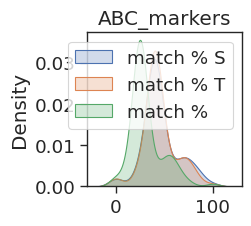

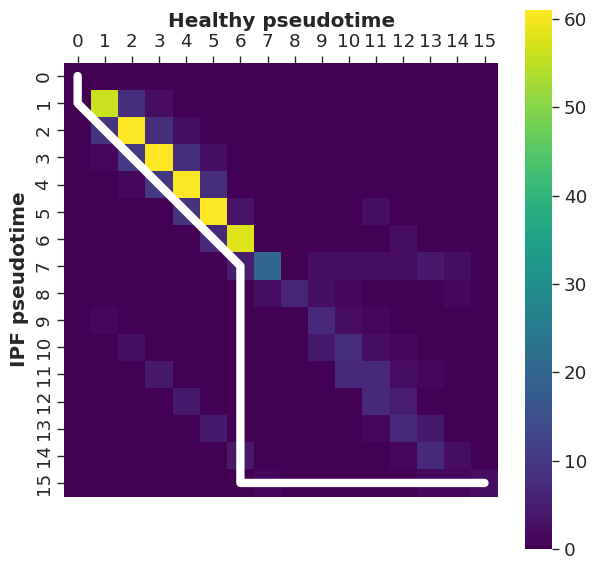

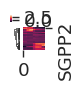

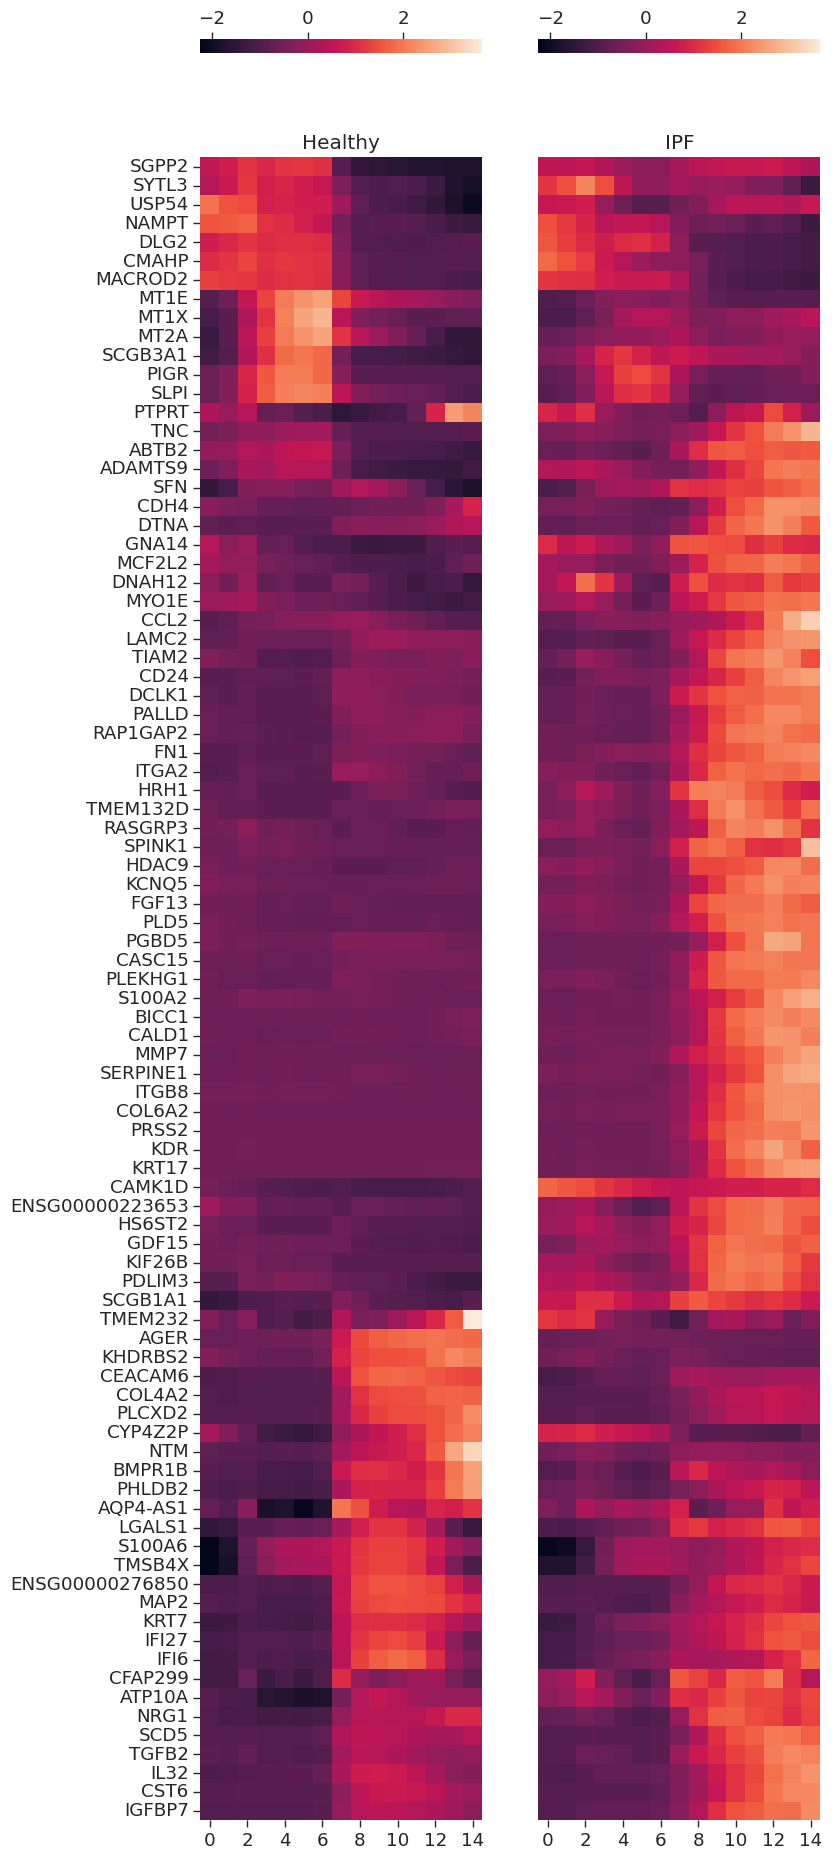

In [175]:
d = pd.read_csv('Z_ABC_Markers_from original_paper_aba1983_data_s2.txt', sep='\t')
IGS.add_new_set( np.intersect1d(common_hvg_genes,  np.asarray(d[d.cellType=='Aberrant Basaloid'].gene) ), 'ABC_markers' , common_hvg_genes )
get_pathway_alignment_stat(aligner, 'ABC_markers', cluster=True)

In [147]:
len( IGS.SETS['ABC_markers'])

88

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PATHWAY =======  all_mismatched
mean matched percentage:  0.0 %
mean matched percentage wrt ref:  0.0 %
mean matched percentage wrt query:  0.0 %
Average Alignment:  IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD


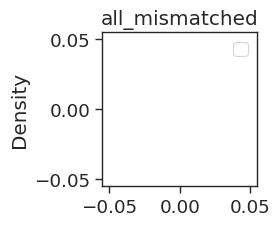

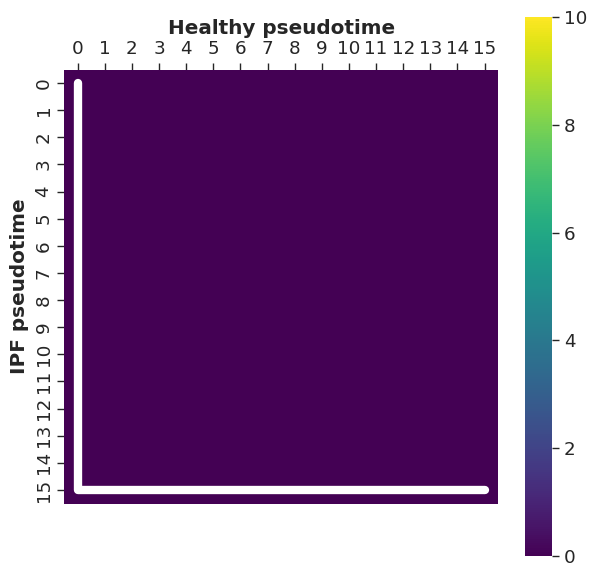

In [146]:
def plot_alignment_path_on_given_matrix(mat, paths, cmap='viridis'):

        fig,ax = plt.subplots(1,1, figsize=(7,7))
        sb.heatmap(mat, square=True, cmap='viridis', ax=ax, cbar=True,xticklabels=True, yticklabels=True, vmin=0, vmax=10)  
        for path in paths: 
            path_x = [p[0]+0.5 for p in path]
            path_y = [p[1]+0.5 for p in path]
            ax.plot(path_y, path_x, color='white', linewidth=6)
        plt.xlabel("Reference pseudotime",fontweight='bold')
        plt.ylabel("Organoid pseudotime",fontweight='bold')
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')    
        
alignment_path,mat= get_pathway_alignment_stat(aligner, 'all_mismatched', cluster=True)
plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat)
plt.xlabel('Healthy pseudotime')
plt.ylabel('IPF pseudotime')
plt.savefig('Healthy_vs_IPF_all_mismatched_overall_alignment.png')

In [228]:
d = d[d.cellType=='Aberrant Basaloid']
d = d.set_index('gene')

PATHWAY =======  EMT
mean matched percentage:  28.33 %
mean matched percentage wrt ref:  42.62 %
mean matched percentage wrt query:  40.95 %
Average Alignment:  IMMMMMMIIIIIIIIDDDDDDDDD
Z-normalised Interpolated mean trends


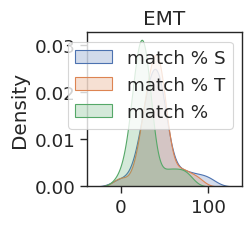

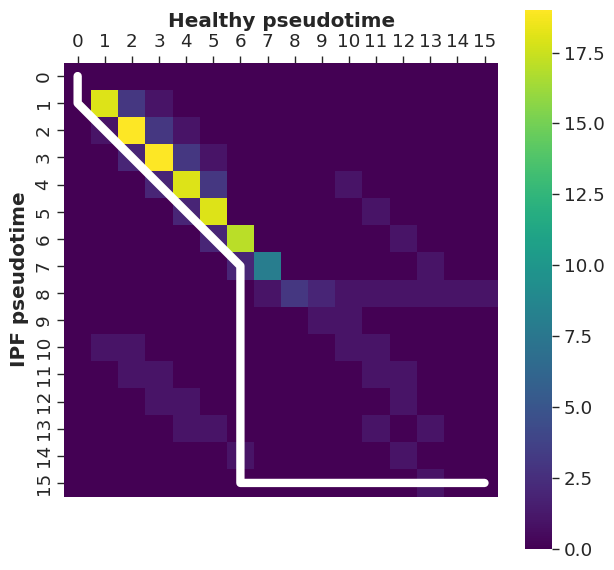

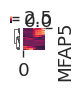

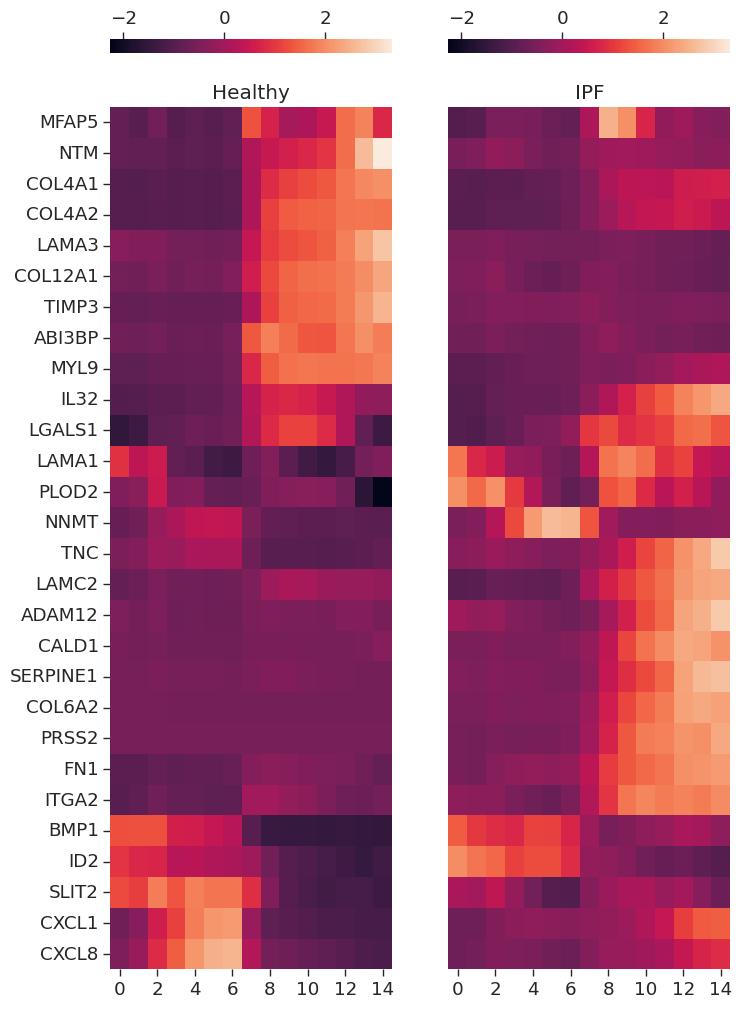

In [167]:
get_pathway_alignment_stat(aligner, 'EMT', cluster=True)

PATHWAY =======  IL17
mean matched percentage:  29.83 %
mean matched percentage wrt ref:  41.34 %
mean matched percentage wrt query:  45.34 %
Average Alignment:  IIIMVVVVVMMMMMIDDDDDDDDD
Z-normalised Interpolated mean trends


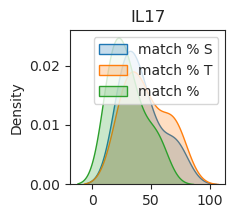

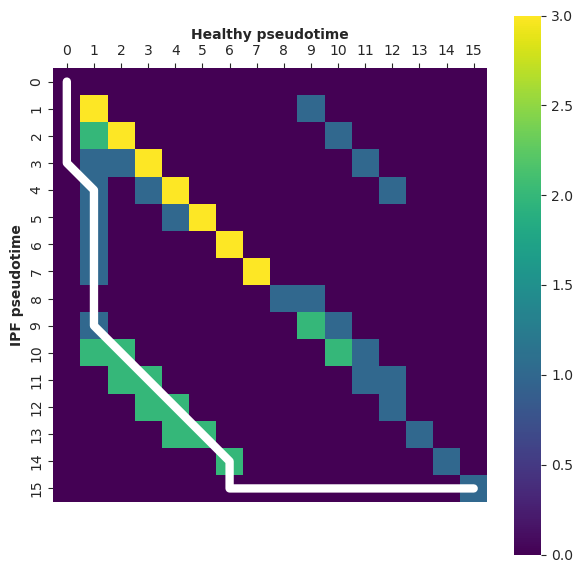

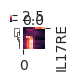

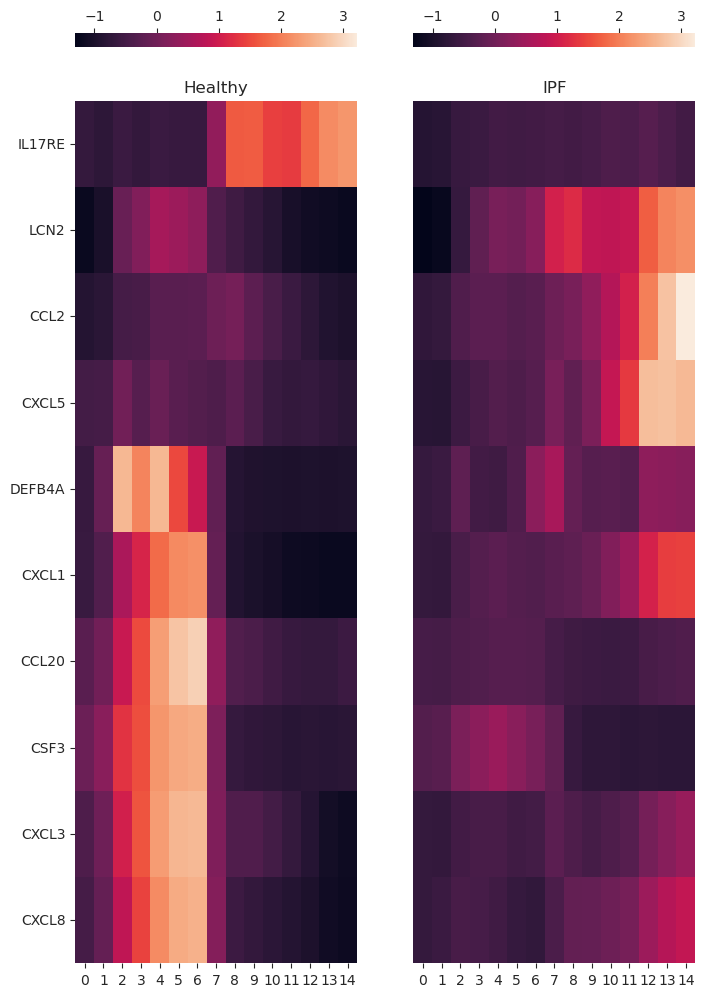

In [31]:
get_pathway_alignment_stat(aligner, 'IL17', cluster=True)

PATHWAY =======  COAGULATION
mean matched percentage:  33.21 %
mean matched percentage wrt ref:  47.41 %
mean matched percentage wrt query:  43.7 %
Average Alignment:  IIDMMMMMIIIIIIIIDDDDDDDDD
Z-normalised Interpolated mean trends


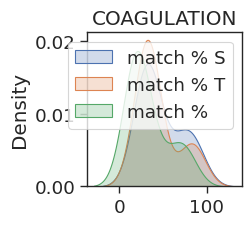

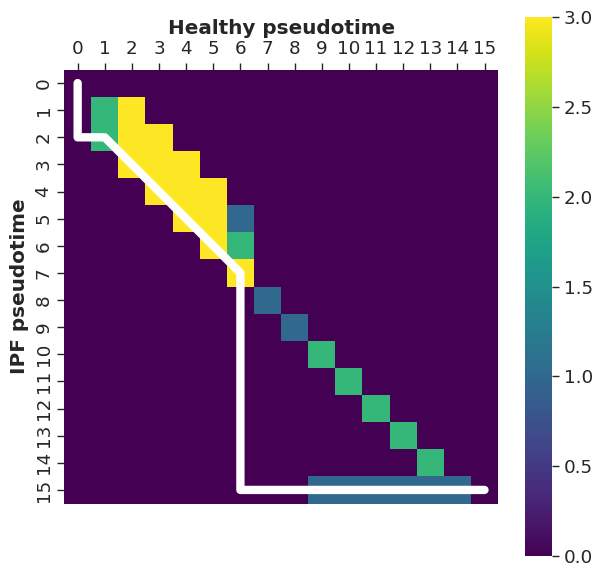

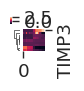

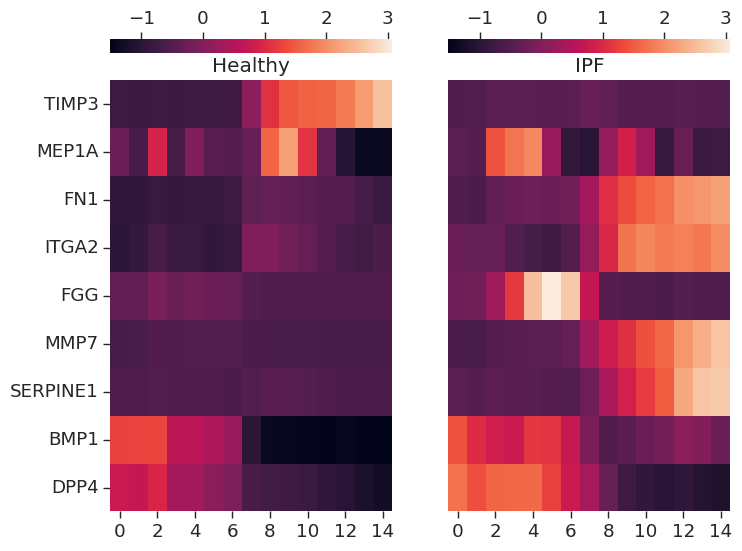

In [98]:
get_pathway_alignment_stat(aligner, 'COAGULATION', cluster=True)

PATHWAY =======  INFLAMMATORY_RESPONSE
mean matched percentage:  37.35 %
mean matched percentage wrt ref:  49.26 %
mean matched percentage wrt query:  49.26 %
Average Alignment:  IMMMMMMIIIIIIIIDDDDDDDDD
Z-normalised Interpolated mean trends


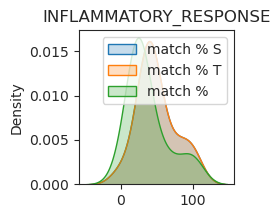

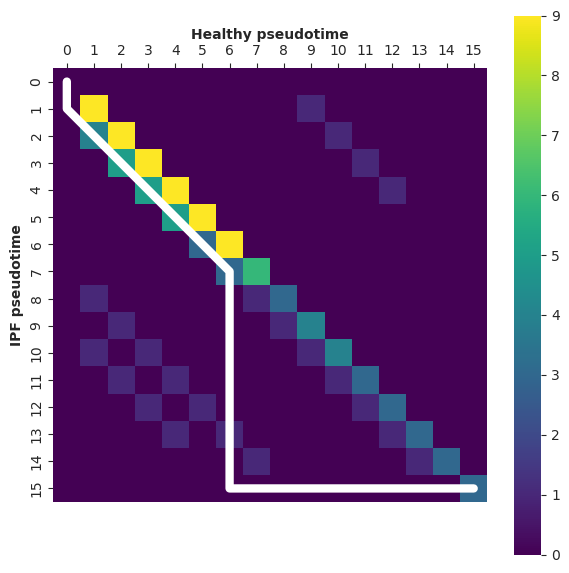

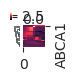

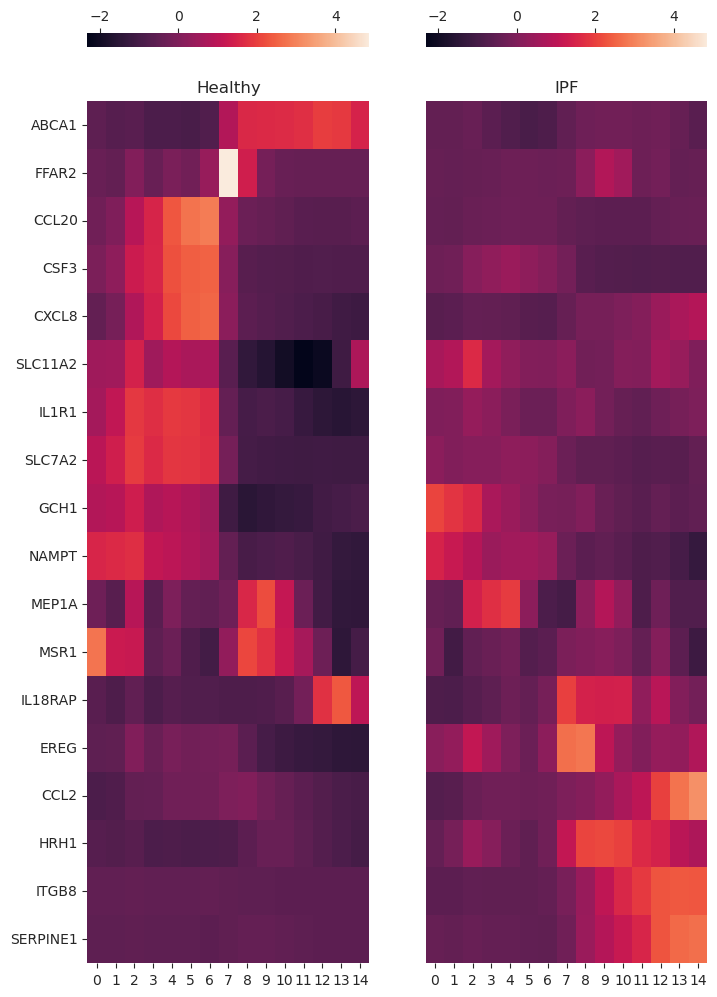

In [30]:
get_pathway_alignment_stat(aligner, 'INFLAMMATORY_RESPONSE', cluster=True)

CCL20 DDDDDDDDMMMMDDDIIIIIIIIIII
CSF3 IMMMMIIIDDDDMMMMMMM
CXCL8 IIIIIIIIIMMMMIIDDDDDDDDDDD
FFAR2 IIIIIIIMMMMMMMIDDDDDDDD
IL18RAP IMMMMMMIIIIIIIIDDDDDDDDD
IL1R1 IMMMMIIIIIIIIIIDDDDDDDDDDD
MEP1A IMMMMMMMMMMMMMIDD
SERPINE1 IIDMMMMMIIIIIIIIDDDDDDDDD
SLC7A2 IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD


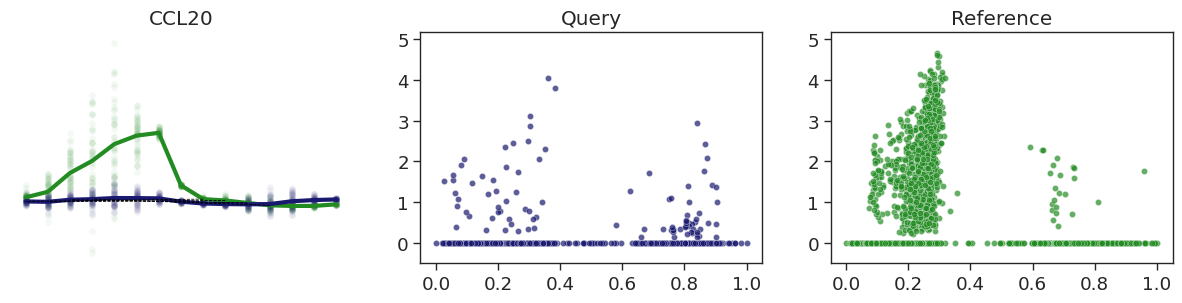

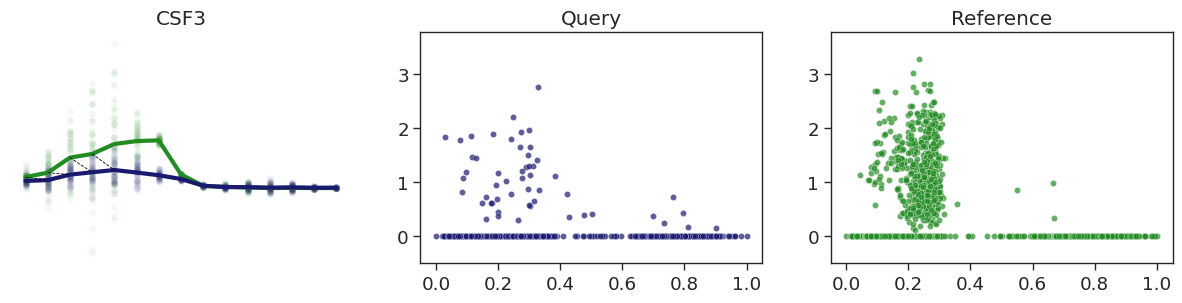

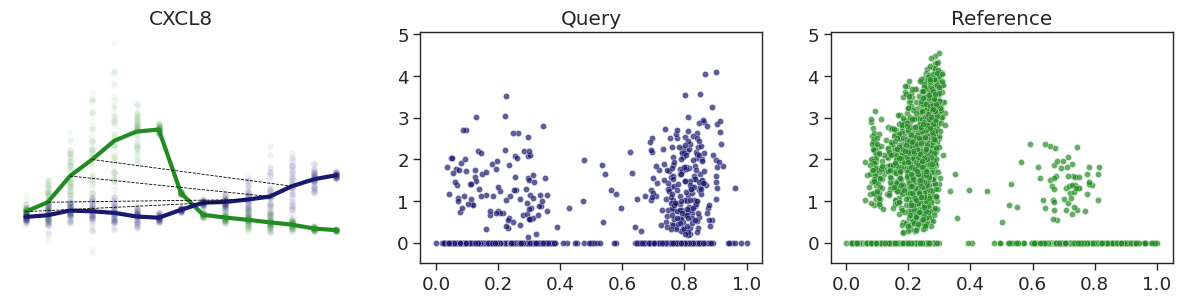

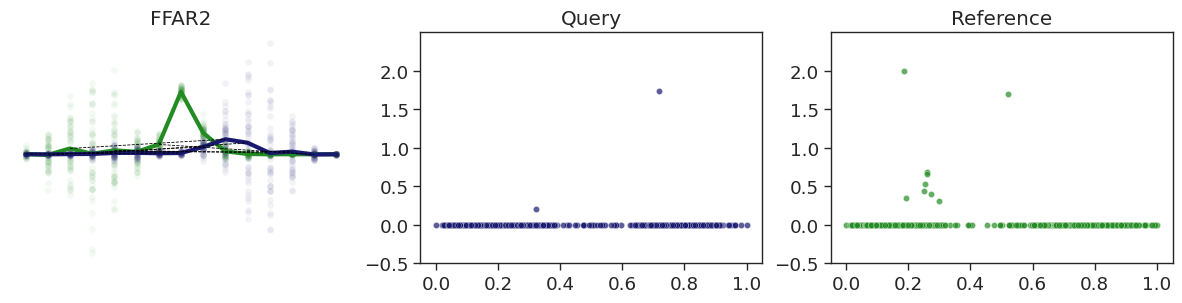

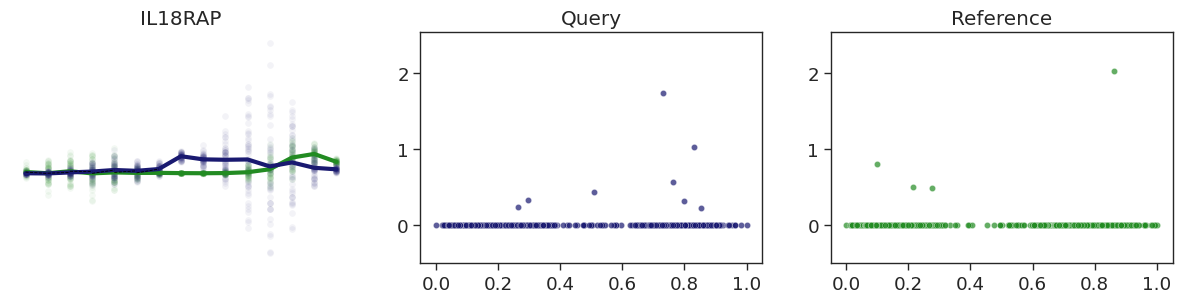

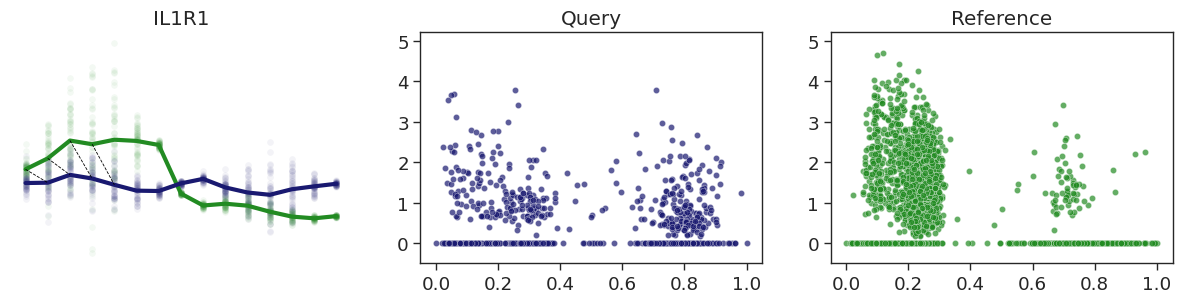

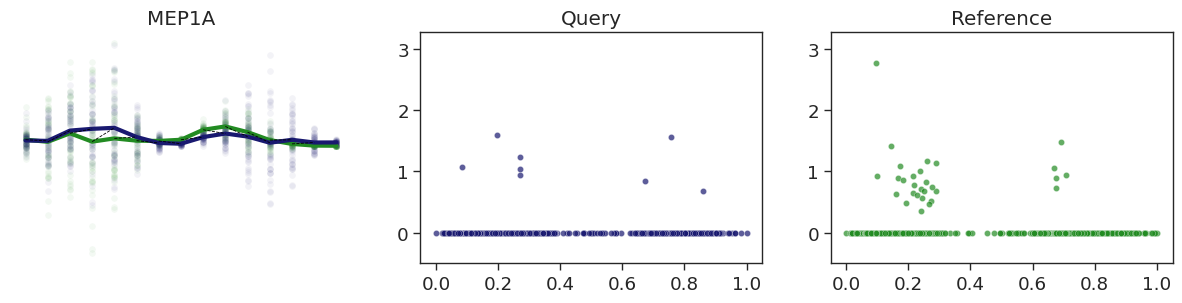

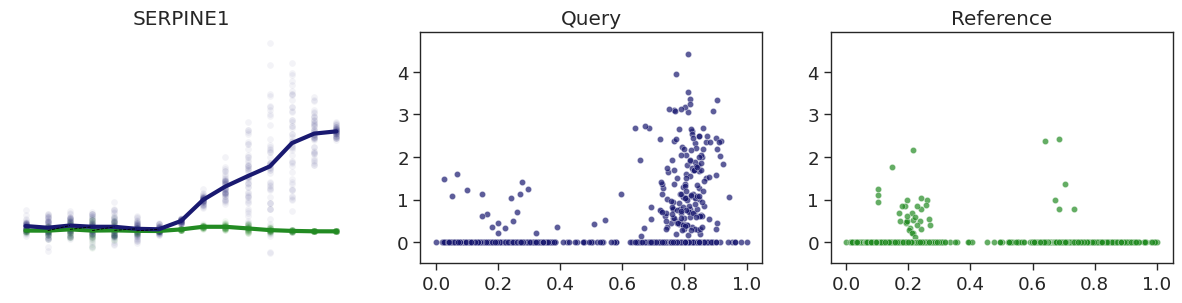

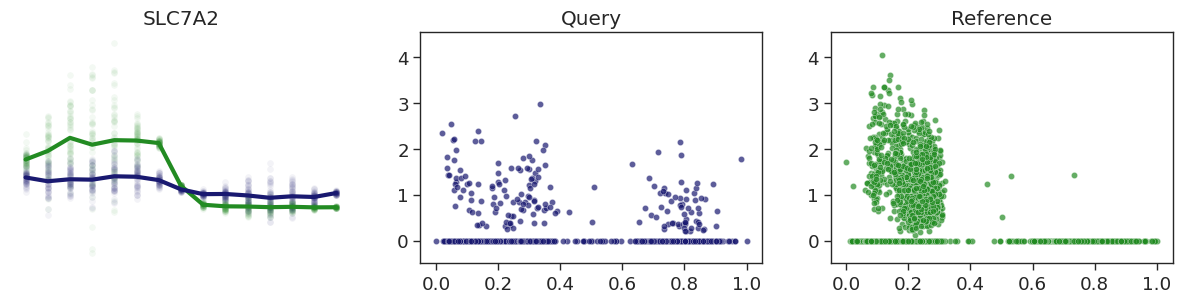

In [41]:
for g in IGS.SETS['INFLAMMATORY_RESPONSE']:
    if(aligner.results_map[g].alignment_str[0] in ['I','D']):
        print(g,aligner.results_map[g].alignment_str)
        VisualUtils.plotTimeSeries(aligner.results_map[g], aligner, plot_cells=True) 

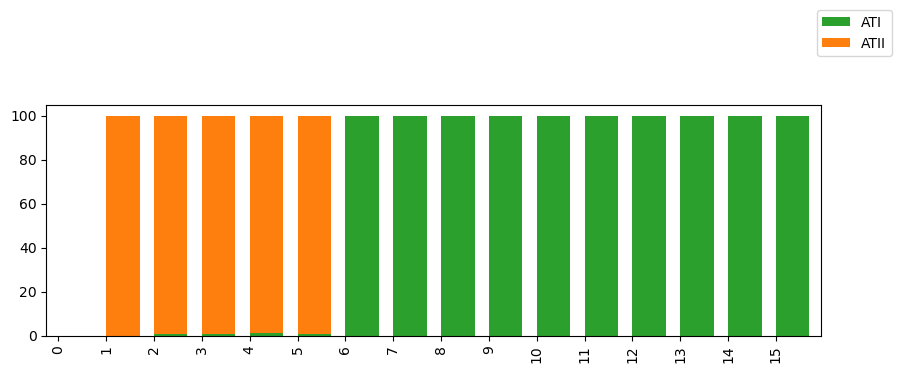

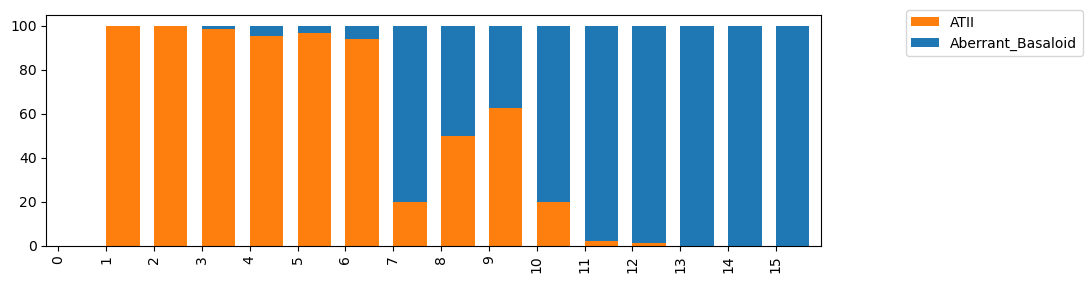

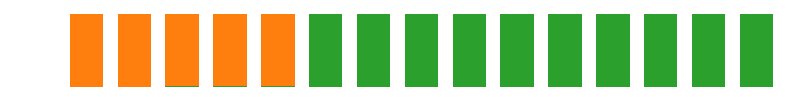

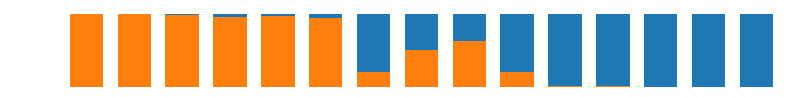

In [139]:
# Bins visualisation --- Each cell is annotatated with its respective bin based on the closest interpolated pseudotime point
# There n_artificial_points = 15 bin margins within the [0,1) range 
# for all cells with pseudotime t>=bin_margins[i] and t<bin_margins[i+1], allocate bin id as i; 
# for final bin  t>=bin_margins[i] and t<=bin_margins[i+1]
# then we plot cell type proportions for each bin 0-14
import colorcet as cc
a = sb.color_palette(cc.glasbey_hv, n_colors=3)

vega_20 = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728',
    '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2',
    '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
]
ref_cmap = { 
            'ATII': vega_20[2],
            'ATI':  vega_20[4],
           }
ipf_cmap = { 
            'ATII': vega_20[2],
            'Aberrant_Basaloid':  vega_20[0],
           }

ref_cmap = [vega_20[4],vega_20[2]] 
ipf_cmap = [vega_20[2], vega_20[0]] 



import colorcet as cc
vs = VisualUtils.VisualUtils(adata_ref, adata_query, cell_type_colname = 'ANNOTATION', 
                S_len=15, 
                T_len=15, 
                titleS='Healthy (Reference)', titleT='IPF (Query)',
                write_file=False)

ax = vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=ref_cmap, grid = False, legend=True, width=0.7,align='edge',figsize=(10,3))

ax.legend(bbox_to_anchor=(1.1, 1.44))
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=[handles[idx] for idx in order_S_legend],labels=[labels[idx] for idx in order_S_legend],bbox_to_anchor=(1.0, 1.0))
#plt.legend(title='Cell Type',bbox_to_anchor=(1.2, 0.2))
plt.savefig('ms_figs/timelegend1.png', bbox_inches='tight')
ax = vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=ipf_cmap, grid = False, legend=True, width=0.7,align='edge',figsize=(10,3))
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('ms_figs/timelegend2.png', bbox_inches='tight')

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=[handles[idx] for idx in order_T_legend],labels=[labels[idx] for idx in order_T_legend],bbox_to_anchor=(1.0, 1.0))
vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=ref_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))


plt.axis('off')
plt.savefig('ms_figs/healthy_timeline.png')
vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=ipf_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('ms_figs/IPF_timeline.png')

In [174]:
adata_disease.obs.Manuscript_Identity

CellBarcode_Identity
010I_AACACGTCAGTCACTA                  ATII
010I_AACTGGTCATCACCCT     Aberrant_Basaloid
010I_ACACCAAAGTACACCT                  ATII
010I_ACACTGAAGGATGGTC                  ATII
010I_ACGGGCTTCAAACCAC                  ATII
                                ...        
49I-a_GAAATGAGTGCGATAG    Aberrant_Basaloid
49I-a_GATTCAGCAATCTGCA    Aberrant_Basaloid
49I-a_GTCGTAACACTTCGAA                 ATII
59I_GCAGCCAGTAAACCTC                   ATII
59I_TTCCCAGTCCTGCCAT                   ATII
Name: Manuscript_Identity, Length: 890, dtype: category
Categories (2, object): ['ATII', 'Aberrant_Basaloid']

mean matched percentage:  47.73 %
mean matched percentage wrt ref:  61.32 %
mean matched percentage wrt query:  61.11 %


Text(0.5, 0, 'Alignment Similarity Percentage')

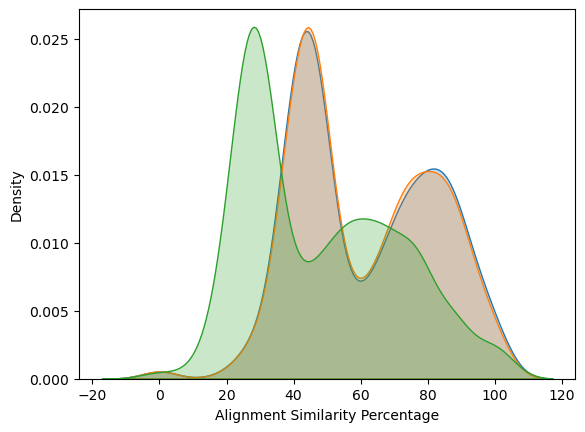

In [110]:
# The overall alignment distribution statistics
import matplotlib as mpl
mpl.style.use('default')
df = aligner.get_match_stat_for_all_genes() 
print('mean matched percentage: ', round(np.mean(df['match %']),2),'%' )
print('mean matched percentage wrt ref: ',round(np.mean(df['match % S']),2),'%'  )
print('mean matched percentage wrt query: ', round(np.mean(df['match % T']),2),'%' )
sb.kdeplot(df['match % S'], fill=True, label='match % Reference')
sb.kdeplot(df['match % T'], fill=True,label='match % Query')
sb.kdeplot(df['match %'], fill=True,label='Alignment Similarity %')
#plt.legend()
plt.xlabel('Alignment Similarity Percentage')

IMMMMIIIIIIIIIIDDDDDDDDDDD
DMMMMDDDDDMMMDDIIIIIIII
IIIIIIIIMMMMMMIDDDDDDDDD
DDMMMIIIIIIIIIIIIDDDDDDDDDD
DMMMMMIIIIIIIIIIDDDDDDDDD
DMMMMIIIIIIIIIIIDDDDDDDDDD


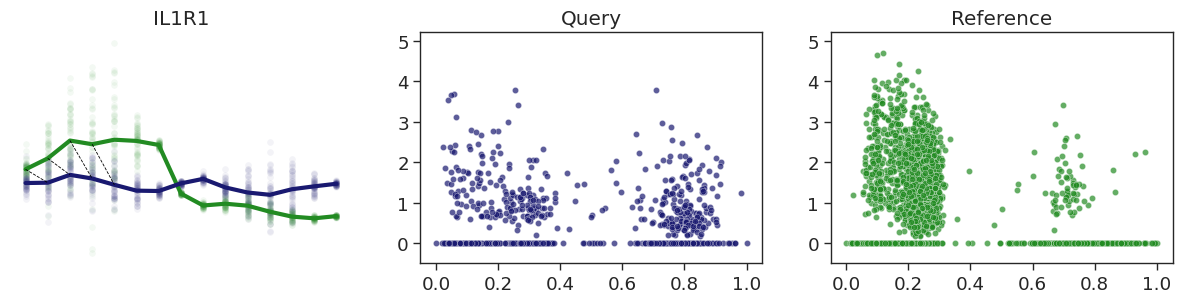

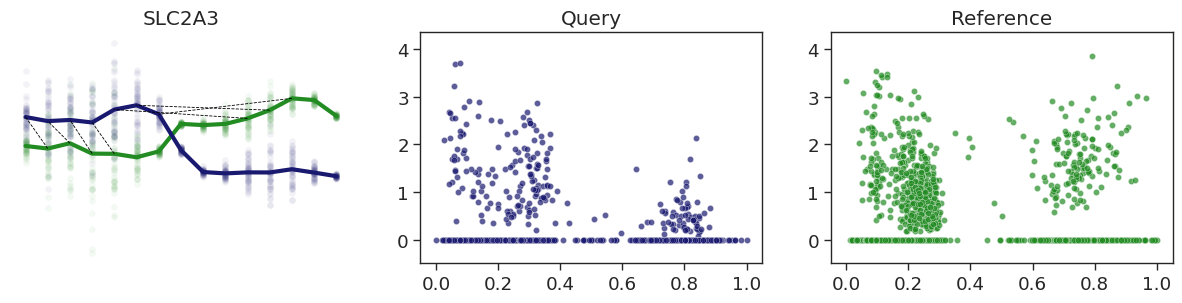

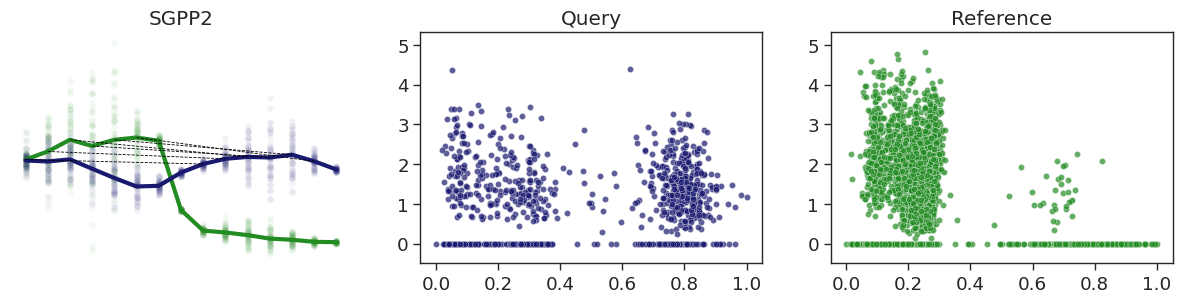

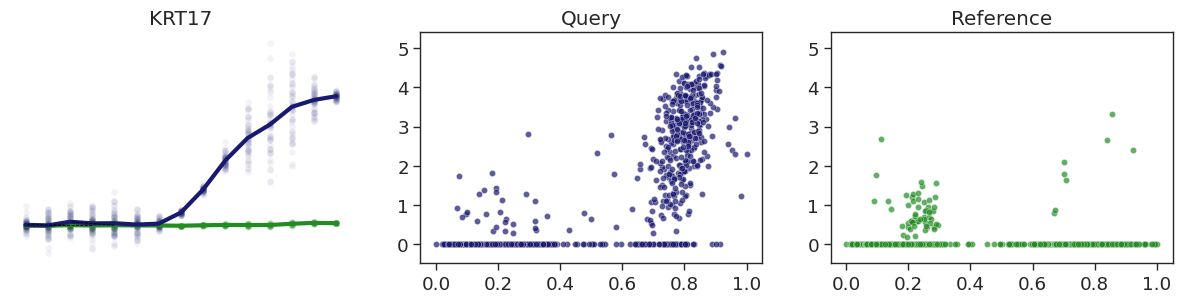

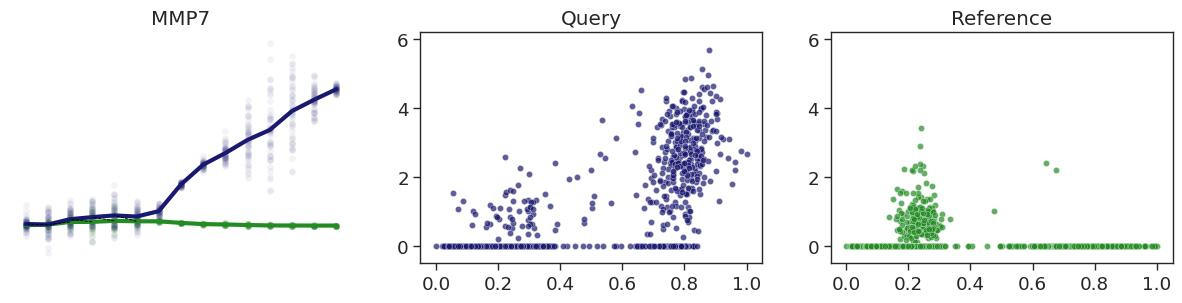

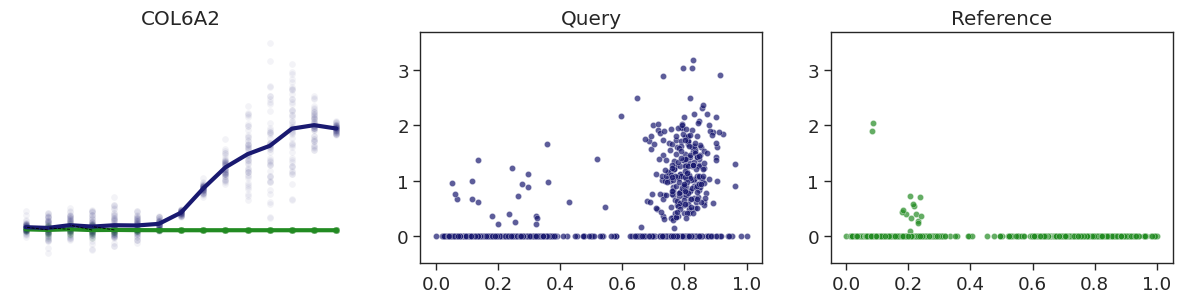

In [27]:
for g in ['IL1R1', 'SLC2A3','SGPP2','KRT17','MMP7','COL6A2']:
    print(aligner.results_map[g].alignment_str)
    VisualUtils.plotTimeSeries(aligner.results_map[g], aligner, plot_cells=True) 

In [15]:
import PathwayAnalyserV2
x =  PathwayAnalyserV2.get_ranked_genelist(aligner)
x = pd.DataFrame(x)

l2fc = []
for gene in x.index:
    ref_gene = np.mean(list(aligner.ref_mat.loc[:,gene]))
    query_gene = np.mean(list(aligner.query_mat.loc[:,gene]))
    if(ref_gene!=0.0 and query_gene!=0.0):
        l2fc.append(np.log2(ref_gene/query_gene )) 
    else:
        l2fc.append(0.0)
        
        
x[2] = l2fc
x.columns = ['sim','l2fc']
x['color'] = np.repeat('green',x.shape[0])
x.loc[x['sim']<=0.5,'color'] = 'red'
x['abs_l2fc'] = np.abs(x['l2fc']) 
x = x.sort_values(['sim','abs_l2fc'],ascending=[True, False])

In [16]:
x

sim      l2fc  color  abs_l2fc
Gene                                           
RCAN2            0.0 -2.794649    red  2.794649
CAMK1D           0.0 -2.513486    red  2.513486
SCGB1A1          0.0 -2.109715    red  2.109715
SLC7A2           0.0  1.455005    red  1.455005
ENSG00000236039  0.0  1.330067    red  1.330067
...              ...       ...    ...       ...
RIPOR2           1.0  0.325685  green  0.325685
MSR1             1.0  0.225702  green  0.225702
ENSG00000237461  1.0 -0.211068  green  0.211068
SLC8A1           1.0 -0.111497  green  0.111497
MIA-RAB4B        1.0  0.095632  green  0.095632

[994 rows x 4 columns]

### Interesting genes that have low l2fc (<=0.3)  but high dissimilarity in alignment (between 1% and 20% alignment similarity )

KRT17 0.11109999999999999 -5.92571663800893
COL6A2 0.15380000000000002 -6.9658893366962475
IL1R1 0.15380000000000002 0.8536541643863774
MMP7 0.2 -4.067353780219494
SGPP2 0.25 0.12150457921777015
SLC2A3 0.3043 -0.06335823631841365


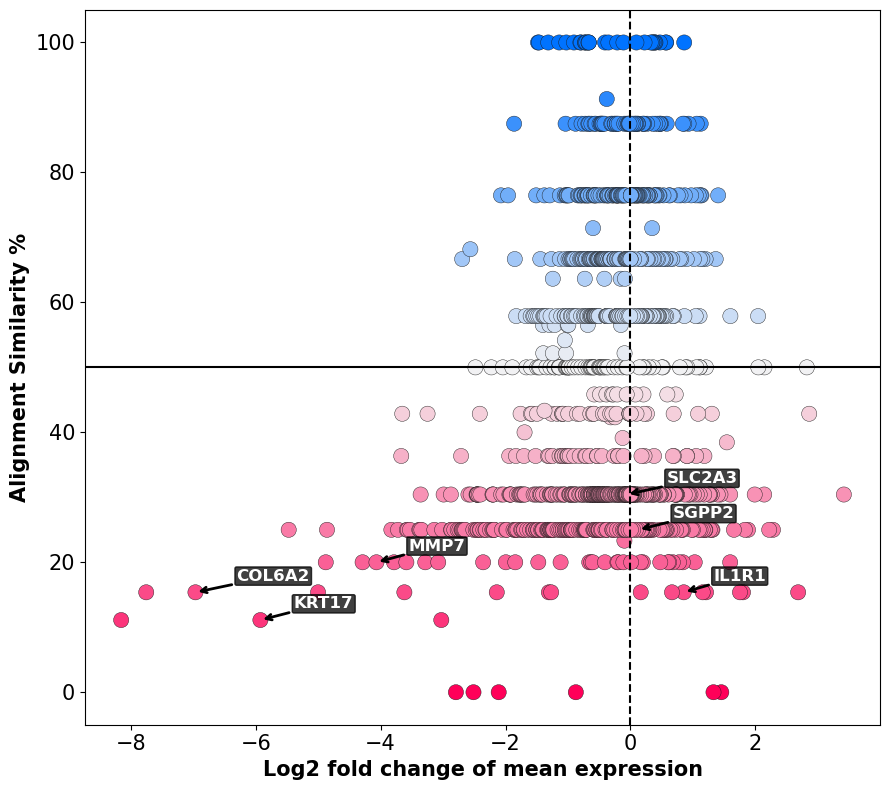

In [150]:
from adjustText import adjust_text
interesting_l2fcs = []
interesting_genes = []

def plot_alignmentSim_vs_l2fc(x):
    plt.subplots(1,1,figsize=(9,8))
    ax=sb.scatterplot(x=x['l2fc'],y=x['sim']*100,s=120, legend=False, hue =x['sim'] ,palette=sb.diverging_palette(0, 255, s=150, as_cmap=True),edgecolor='k',linewidth=0.3)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel('Alignment Similarity %', fontsize=15, fontweight='bold')
    plt.xlabel('Log2 fold change of mean expression', fontsize = 15, fontweight='bold')
    
    
    TEXTS = [] 
    for i, gene in enumerate (x.index):
        #if( x['sim'][i] <=0.2 and x['sim'][i] >=0.01   and np.abs(x['l2fc'][i]) <=0.3):
        if(gene in ['KRT17','MMP7','IL1R1','COL6A2','SLC2A3','SGPP2']):
            print(gene,x['sim'][i], x['l2fc'][i] )
            TEXTS.append(ax.text(x['l2fc'][i], x['sim'][i]*100, x.index[i], color='white', fontsize=12, fontweight='bold',bbox=dict(boxstyle='round,pad=0.1', fc='black', alpha=0.75)))
            interesting_l2fcs.append(x['l2fc'][i])
            interesting_genes.append(gene)
    adjust_text(TEXTS, expand_points=(2, 2),arrowprops=dict(arrowstyle="->", color='black', lw=2))

    plt.grid(False)
    plt.axhline(50, color='black')
    plt.axvline(0, color='black', linestyle='dashed')
    plt.tight_layout()

# 
plot_alignmentSim_vs_l2fc(x)
plt.savefig('ms_figs/volcano_like_DEPlot.png')

### Top 20 genes with very low alignment similarity 

In [125]:
x[0:20]

sim      l2fc color  abs_l2fc
Gene                                             
RCAN2            0.0000 -2.794649   red  2.794649
CAMK1D           0.0000 -2.513486   red  2.513486
SCGB1A1          0.0000 -2.109715   red  2.109715
SLC7A2           0.0000  1.455005   red  1.455005
ENSG00000236039  0.0000  1.330067   red  1.330067
NTM              0.0000 -0.874262   red  0.874262
PRSS2            0.1111 -8.155662   red  8.155662
KRT17            0.1111 -5.925717   red  5.925717
SYT8             0.1111 -3.029059   red  3.029059
KDR              0.1538 -7.754227   red  7.754227
COL6A2           0.1538 -6.965889   red  6.965889
BICC1            0.1538 -5.002696   red  5.002696
SYCP2            0.1538 -3.620247   red  3.620247
CCL20            0.1538  2.685617   red  2.685617
FN1              0.1538 -2.140699   red  2.140699
MARCH3           0.1538  1.802428   red  1.802428
DEFB4A           0.1538  1.754385   red  1.754385
SYN3             0.1538 -1.306197   red  1.306197
RNU6-3P          0.1538 -1.269477   red  1.269477
BCYRN1           0.1538  1.210771   red  1.210771

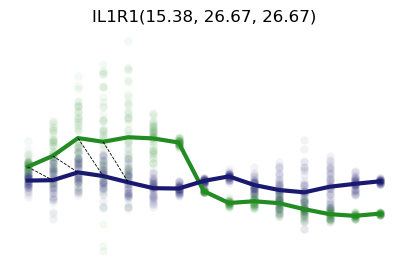

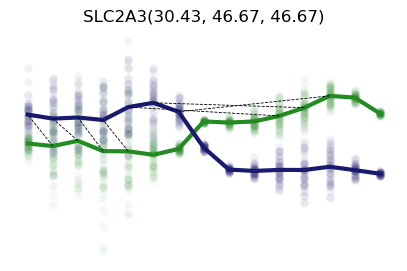

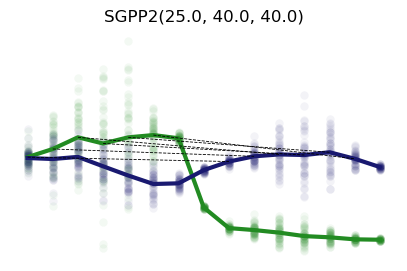

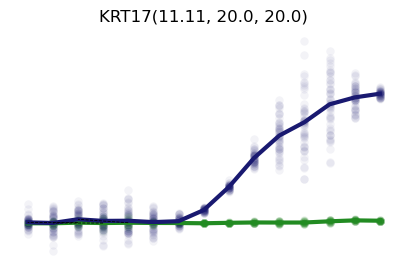

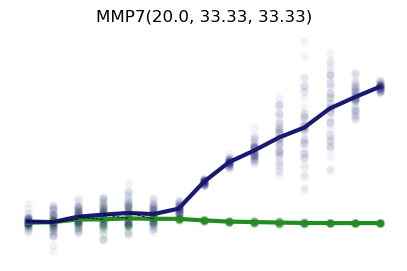

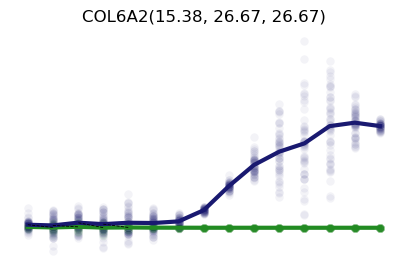

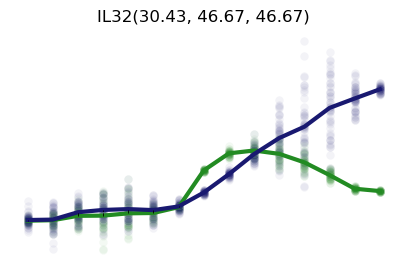

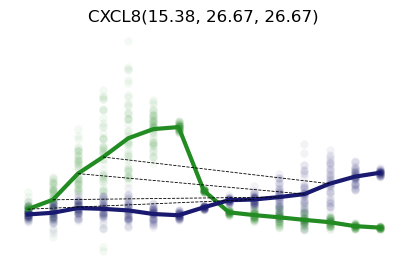

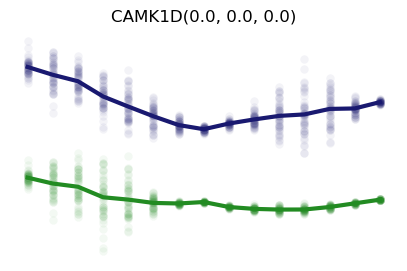

In [140]:
#for g in x[0:20].index:
#    VisualUtils.plotTimeSeries(aligner.results_map[g], aligner, plot_cells=True) 
    
    
def plotTimeSeries(al_obj, refQueryAlignerObj, adata_ref, adata_query, plot_mean_trend= False):
       # plt.subplots(1,3,figsize=(15,3))
        plt.subplots(1,1,figsize=(5,3))
       # plt.subplot(1,3,1)
        plotTimeSeriesAlignment(al_obj) 
        return 
        plt.subplot(1,3,2)
        
        query_capture_time_labels = np.asarray(adata_query.obs.time)
        ref_capture_time_labels = np.asarray(adata_ref.obs.time)

        g = sb.scatterplot(refQueryAlignerObj.query_time, np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]), hue=query_capture_time_labels,  
                           palette=sb.color_palette("light:#191970", as_cmap=True), legend=False, edgecolor='k',linewidth=0.3) 
        plt.title('Organoid')
        plt.xlabel('pseudotime')
        plt.ylabel('log1p expression')
        sb.scatterplot(x=refQueryAlignerObj.ref_time, y=np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene]), color = 'black', alpha=0.1, legend=False, marker='+')
        plt.subplot(1,3,3)
        sb.scatterplot(x=refQueryAlignerObj.ref_time, y=np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene]), color = 'forestgreen', hue=ref_capture_time_labels, 
                         palette=sb.color_palette("blend:#C8DBC8,#94C47D,#628D56,#335A30", as_cmap=True), legend=False, edgecolor='k',linewidth=0.3 )
        plt.title('Reference')
        plt.xlabel('pseudotime')
        plt.ylabel('log1p expression')
        sb.scatterplot(refQueryAlignerObj.query_time, np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]), color = 'black', alpha=0.1, legend=False, marker='+')
        
            
def plotTimeSeriesAlignment(al_obj):  
        sb.scatterplot(x=al_obj.S.X, y=al_obj.S.Y, color = 'forestgreen' ,alpha=0.05, legend=False)#, label='Ref') 
        sb.scatterplot(x=al_obj.T.X, y=al_obj.T.Y, color = 'midnightblue' ,alpha=0.05, legend=False)#, label ='Query') 
       # plt.legend(loc='upper left')
        #al_obj.plot_mean_trends() 
        al_obj.S.plot_mean_trend(color='forestgreen')
        al_obj.T.plot_mean_trend(color='midnightblue')
        plt.title(al_obj.gene + str(al_obj.get_series_match_percentage()))
        plt.xlabel('pseudotime')
        plt.ylabel('log1p expression')
        plt.axis('off')
        
        for i in range(al_obj.matched_region_DE_info.shape[0]):
            S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
            T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin']) 
            x_vals = [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
            y_vals = [al_obj.S.mean_trend[S_timebin ], al_obj.T.mean_trend[T_timebin]] 
            plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=0.6)
            
def plot_boxplots(geneset, adata_R, adata_Q):
    i=1
    plt.subplots(2,5,figsize=(15,6))
    for gene in geneset:
        ref_data = list(np.asarray(adata_R[:,gene].X.todense()).flatten()) 
        query_data = list(np.asarray(adata_Q[:,gene].X.todense()).flatten())
        df = pd.DataFrame([ref_data+ query_data,list(np.repeat('Reference', len(ref_data))) + list(np.repeat('Organoid', len(query_data))) ]).transpose()
        df.columns = ['expr','system']
        df['expr'] = np.asarray(df['expr'], dtype=float)
        plt.subplot(2,5,i)
        ax = sb.boxplot(data=df, y='expr',x='system', palette=['forestgreen','midnightblue'], width =0.5, notch=True, showcaps=False,flierprops={"marker": "x"}, 
                       boxprops={ 'edgecolor':'grey'})#, alpha=0.1) 
        plt.setp(ax.collections, alpha=.3)
        plt.xlabel('')
        plt.ylabel('Gene Expression', fontsize=10)
        plt.xticks(fontsize=6)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        plt.grid(False)
        plt.title(gene, fontsize=12)
        plt.tight_layout()
        ax.set(xticklabels=[])
        ax.set(xticks=[])
        i=i+1
        if(i==11):
            break

for g in ['IL1R1', 'SLC2A3','SGPP2','KRT17','MMP7','COL6A2','IL32','CXCL8','CAMK1D']:
    plotTimeSeries(aligner.results_map[g], aligner, adata_ref, adata_query)
    plt.savefig('ms_figs/'+g+'.png', bbox_inches = 'tight')
#plotTimeSeries(aligner.results_map['ARID5B'], aligner, adata_ref, adata_query)
#plt.savefig('ARID5B_cd8.pdf', bbox_inches = 'tight')
#plotTimeSeries(aligner.results_map['SOX4'], aligner, adata_ref, adata_query)
#plt.savefig('SOX4_cd8.pdf', bbox_inches = 'tight')
#plotTimeSeries(aligner.results_map['BHLHE40'], aligner, adata_ref, adata_query)
#plt.savefig('BHLHE40_cd8.pdf', bbox_inches = 'tight')

### Overrepresentation analysis of Top genes <25% similarity in alignment 

In [ ]:
def topkDE(aligner, DIFF_THRESHOLD=0.5):
        ranked_list = get_ranked_genelist(aligner)
        top_k = np.unique(ranked_list ['Alignment_Percentage'] < DIFF_THRESHOLD , return_counts=True)[1][1]
        print(top_k, ' # of DE genes to check')
        clusters = pd.DataFrame([ranked_list[0:top_k].index, np.repeat(0,top_k)]).transpose()
        clusters.columns = ['Gene','ClusterID']
        clusters = clusters.set_index('Gene')
        return list(clusters.index), ranked_list 

In [38]:
import PathwayAnalyserV2
# Overrepresentation analysis of the top DE genes along pseudotime based on alignment percentage < 25% 
topDEgenes,rankedDEgenes = PathwayAnalyserV2.topkDE(aligner, DIFF_THRESHOLD=0.25)
df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes)

55  # of DE genes to check


Pathways  \
0                   Epithelial Mesenchymal Transition   
1                                         Coagulation   
2                               Inflammatory Response   
21                            IL-17 signaling pathway   
22                                         Amoebiasis   
3                       TNF-alpha Signaling via NF-kB   
4                                   KRAS Signaling Up   
23                           ECM-receptor interaction   
24                               Rheumatoid arthritis   
25                                     Focal adhesion   
26                            Proteoglycans in cancer   
27  AGE-RAGE signaling pathway in diabetic complic...   
28  Viral protein interaction with cytokine and cy...   
29                       NF-kappa B signaling pathway   

                                        Pathway genes                Source  
0   CXCL8;NNMT;ITGA2;COL6A2;NTM;SERPINE1;FN1;TIMP3...  MSigDB_Hallmark_2020  
1                       MMP7;ITGA2;SERPINE1;FN1;TIMP3  MSigDB_Hallmark_2020  
2                   CXCL8;IL1R1;CCL20;SERPINE1;SLC7A2  MSigDB_Hallmark_2020  
21                           CXCL8;CCL20;CXCL1;DEFB4A       KEGG_2021_Human  
22                              CXCL8;IL1R1;FN1;CXCL1       KEGG_2021_Human  
3                          CCL20;SERPINE1;CXCL1;PLPP3  MSigDB_Hallmark_2020  
4                           CCL20;ITGA2;HKDC1;ANGPTL4  MSigDB_Hallmark_2020  
23                                   ITGA2;COL6A2;FN1       KEGG_2021_Human  
24                                  CXCL8;CCL20;CXCL1       KEGG_2021_Human  
25                               ITGA2;COL6A2;FN1;KDR       KEGG_2021_Human  
26                                ITGA2;FN1;KDR;TIMP3       KEGG_2021_Human  
27                                 CXCL8;SERPINE1;FN1       KEGG_2021_Human  
28                                  CXCL8;CCL20;CXCL1       KEGG_2021_Human  
29                                  CXCL8;IL1R1;CXCL1       KEGG_2021_Human

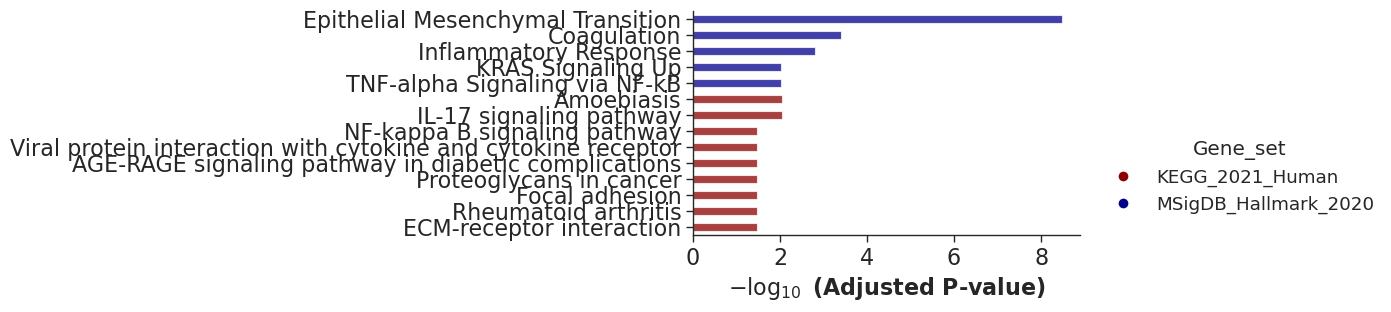

In [39]:
PathwayAnalyserV2.plot_overrep_results(df)
df = pd.DataFrame([df.Term, df.Genes, df.Gene_set]).transpose() 
df.columns = ['Pathways','Pathway genes','Source']
df

In [114]:
pickle.dump(df, open('df_enrichr_top55DE_healthyIPF.pkl', 'wb')) 

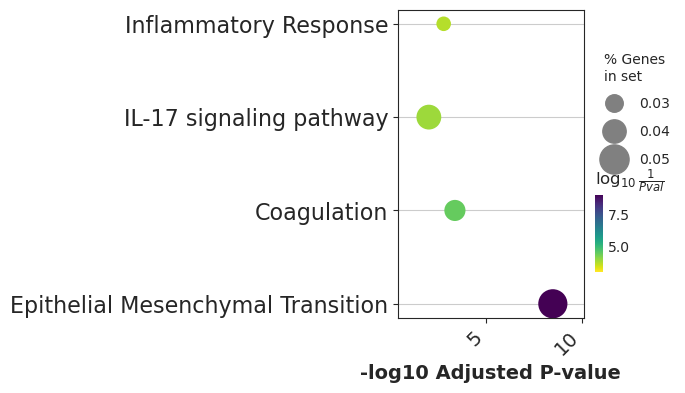

In [70]:
from gseapy import  dotplot
# start capital_test kernel to produce dotplots (due to matplotlib version conflict, under python3 kernel we cannot make dotplots)
# start capital_test kernel to produce dotplots (due to matplotlib version conflict, under python3 kernel we cannot make dotplots)
with open('df_enrichr_top55DE_healthyIPF.pkl', 'rb') as f:
    df = pickle.load(f)
df_top = df.sort_values('Adjusted P-value')[0:4]
# categorical scatterplot
#df = df[0:15]
ax = dotplot(df_top,
              column="P-value",
              x='-log10 Adjusted P-value', # set x axis, so you could do a multi-sample/library comparsion
              size=70,
              top_term=4,
              figsize=(3,4),
              xticklabels_rot=45, # rotate xtick labels
              show_ring=False, # set to False to revmove outer ring
              marker='o',
             )

plt.savefig('ms_figs/df_enrichr_top55DE_IPF.pdf',  bbox_inches='tight')

# Writing results files

In [ ]:
import PathwayAnalyserV2

# Cluster specific overepresentation analysis ---> Clusters do not necessarily output similar gene programs -- If one pathway is overrepresented in several clusters, that means 
# that particular pathway has several gene subsets which match/mismatch differently along pseudotime. 
# Such clusters reveal pathways with such varying alignments
# They could be DE or non DE; Also a cluster might not have any significant overepresentation result as well
from tqdm import tqdm
import gseapy as gp
from gseapy import barplot, dotplot
import anndata
import time 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import os,sys,inspect
import pickle
from tqdm import tqdm
from tabulate import tabulate
def run_overrepresentation_analysis(gene_set, TARGET_GENESETS=['MSigDB_Hallmark_2020','KEGG_2021_Human']):
    enr = gp.enrichr(gene_list=gene_set,
                     gene_sets=TARGET_GENESETS,
                     organism='human',
                     outdir=None,
                       )
    df = enr.results[enr.results['Adjusted P-value']<0.05]
    if(df.shape[0]==0):
        return df
    df = df.sort_values('Adjusted P-value')
    df['-log10 Adjusted P-value'] = [-np.log10(q) for q in df['Adjusted P-value']]
    max_q = max(df['-log10 Adjusted P-value'][df['-log10 Adjusted P-value']!=np.inf])
    #df.columns = ['Gene_set']+list(df.columns[1:len(df.columns)])
    qvals = []
    for q in df['-log10 Adjusted P-value']:
        if(q==np.inf):
            q = -np.log10(0.00000000001) # NOTE: For -log10(p=0.0) we replace p with a very small p-val to avoid inf
        qvals.append(q)
    df['-log10 FDR q-val'] = qvals 
    df = df.sort_values('Adjusted P-value',ascending=True)
    return df
def run_cluster_overrepresentation_analysis(aligner):

    overrep_cluster_results = {}
    cluster_overrepresentation_results = [] 

    for cluster_id in tqdm(range(len(aligner.gene_clusters))):
        df = run_overrepresentation_analysis(aligner.gene_clusters[cluster_id])
        if(df.shape[0]==0):
            continue
        n_genes = len(aligner.gene_clusters[cluster_id])
        pathways = list(df.Term) 
        pathway_specific_genes = list(df.Genes) 
        sources = [str(s).split('_')[0] for s in list(df.Gene_set)] 

        if(n_genes<15):
            genes = aligner.gene_clusters[cluster_id]
        else:
            genes = aligner.gene_clusters[cluster_id][1:7] + [' ... '] +  aligner.gene_clusters[cluster_id][n_genes-7:n_genes]

        cluster_overrepresentation_results.append([cluster_id,n_genes,genes,pathways, pathway_specific_genes, sources]) 
        overrep_cluster_results[cluster_id] = df 

    results= pd.DataFrame(cluster_overrepresentation_results)
    #print(tabulate(results,  headers=['cluster_id','n_genes', 'Cluster genes', 'Pathways','Pathway genes','Source'],tablefmt="grid",maxcolwidths=[3, 3, 3,30,40,40,10])) 
    return overrep_cluster_results, results
    
#PathwayAnalyserV2.run_cluster_overrepresentation_analysis(aligner)
overrep_cluster_results, results = run_cluster_overrepresentation_analysis(aligner)
cid = 0
for cluster in aligner.gene_clusters:
    print(cid)
    for g in cluster:
        aligner.results_map[g].cluster_id = cid
    cid+=1
    

In [79]:
df = []
for g in aligner.gene_list:
    al_obj = aligner.results_map[g]
    df.append([g, al_obj.alignment_str, al_obj.get_series_match_percentage()[0], al_obj.cluster_id ] )
df = pd.DataFrame(df)
df.columns = ['Gene','5-state alignment string','Alignment similarity %','Cluster_id']
df

Gene 5-state alignment string  Alignment similarity %  Cluster_id
0       AASS  IMMMMMMMIIIIIIIDDDDDDDD                   30.43          18
1       AATK      MMMMMMMDMMMMIIIIDDD                   57.89           5
2      ABCA1  MMMMMMMIIIIIIIIDDDDDDDD                   30.43          18
3      ABCA6        MMMMMMMIIDDMMMMMM                   76.47           8
4     ABCC13         MMMMMMMMMMMMMMID                   87.50           5
..       ...                      ...                     ...         ...
989   ZNF773       IMMMMMMMIIDDMMMMMD                   66.67           8
990    ZNF79  MMMMMMMIIIIIIIIDDDDDDDD                   30.43          18
991      ZP3  MMMMMMMDWWWWWIIIIIIIIDD                   52.17           0
992  ZSCAN31        MMMMMMMMMMMMMIIDD                   76.47           5
993   ZSWIM4  MMMMMMMIIIIIIIIDDDDDDDD                   30.43          18

[994 rows x 4 columns]

In [82]:
np.unique(df['Cluster_id'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [83]:
df.to_csv('ms_sup_tables/HealthyIPF_all_gene_alignments.csv')

In [84]:
aligner.gene_clusters[12]

['CAMK1D', 'ENSG00000236039', 'NTM', 'RCAN2', 'SCGB1A1', 'SLC7A2']

In [87]:
df = df.set_index('Gene')
df.loc[aligner.gene_clusters[12]]

5-state alignment string  Alignment similarity %  \
Gene                                                                      
CAMK1D           IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   
ENSG00000236039  IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   
NTM              IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   
RCAN2            IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   
SCGB1A1          IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   
SLC7A2           IIIIIIIIIIIIIIIDDDDDDDDDDDDDDD                     0.0   

                 Cluster_id  
Gene                         
CAMK1D                   12  
ENSG00000236039          12  
NTM                      12  
RCAN2                    12  
SCGB1A1                  12  
SLC7A2                   12

In [90]:
# Overrepresentation analysis of the top DE TFs along pseudotime based on alignment percentage < 40% 
import PathwayAnalyserV2
topDEgenes,rankedDEgenes = PathwayAnalyserV2.topkDE(aligner, DIFF_THRESHOLD=0.25)
df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes)

df

55  # of DE genes to check


Gene_set                                               Term  \
0   MSigDB_Hallmark_2020                  Epithelial Mesenchymal Transition   
1   MSigDB_Hallmark_2020                                        Coagulation   
2   MSigDB_Hallmark_2020                              Inflammatory Response   
21       KEGG_2021_Human                            IL-17 signaling pathway   
22       KEGG_2021_Human                                         Amoebiasis   
3   MSigDB_Hallmark_2020                      TNF-alpha Signaling via NF-kB   
4   MSigDB_Hallmark_2020                                  KRAS Signaling Up   
23       KEGG_2021_Human                           ECM-receptor interaction   
24       KEGG_2021_Human                               Rheumatoid arthritis   
25       KEGG_2021_Human                                     Focal adhesion   
26       KEGG_2021_Human                            Proteoglycans in cancer   
27       KEGG_2021_Human  AGE-RAGE signaling pathway in diabetic complic...   
28       KEGG_2021_Human  Viral protein interaction with cytokine and cy...   
29       KEGG_2021_Human                       NF-kappa B signaling pathway   

   Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   10/200  1.578265e-10      3.314357e-09            0                     0   
1    5/138  3.834432e-05      4.026154e-04            0                     0   
2    5/200  2.205026e-04      1.543518e-03            0                     0   
21    4/94  1.298924e-04      9.082512e-03            0                     0   
22   4/102  1.780885e-04      9.082512e-03            0                     0   
3    4/200  2.222170e-03      9.333112e-03            0                     0   
4    4/200  2.222170e-03      9.333112e-03            0                     0   
23    3/88  1.830470e-03      3.337678e-02            0                     0   
24    3/93  2.143730e-03      3.337678e-02            0                     0   
25   4/201  2.262708e-03      3.337678e-02            0                     0   
26   4/205  2.429976e-03      3.337678e-02            0                     0   
27   3/100  2.635341e-03      3.337678e-02            0                     0   
28   3/100  2.635341e-03      3.337678e-02            0                     0   
29   3/104  2.945010e-03      3.337678e-02            0                     0   

    Odds Ratio  Combined Score  \
0    23.105263      521.474806   
1    14.896241      151.478441   
2    10.128205       85.275446   
21   17.302832      154.839656   
22   15.883954      137.129826   
3     7.902761       48.280112   
4     7.902761       48.280112   
23   13.479638       84.964622   
24   12.727564       78.213526   
25    7.862247       47.890466   
26    7.704224       46.378455   
27   11.804917       70.106361   
28   11.804917       70.106361   
29   11.335110       66.056977   

                                                Genes  \
0   CXCL8;NNMT;ITGA2;COL6A2;NTM;SERPINE1;FN1;TIMP3...   
1                       MMP7;ITGA2;SERPINE1;FN1;TIMP3   
2                   CXCL8;IL1R1;CCL20;SERPINE1;SLC7A2   
21                           CXCL8;CCL20;CXCL1;DEFB4A   
22                              CXCL8;IL1R1;FN1;CXCL1   
3                          CCL20;SERPINE1;CXCL1;PLPP3   
4                           CCL20;ITGA2;HKDC1;ANGPTL4   
23                                   ITGA2;COL6A2;FN1   
24                                  CXCL8;CCL20;CXCL1   
25                               ITGA2;COL6A2;FN1;KDR   
26                                ITGA2;FN1;KDR;TIMP3   
27                                 CXCL8;SERPINE1;FN1   
28                                  CXCL8;CCL20;CXCL1   
29                                  CXCL8;IL1R1;CXCL1   

    -log10 Adjusted P-value  -log10 FDR q-val  
0                  8.479601          8.479601  
1                  3.395110          3.395110  
2                  2.811488          2.811488  
21                 2.041794          2.041794  
22     

In [92]:
df.to_csv('ms_sup_tables/HealthyIPF_all_overrep_results_top_k_DE_threshold_0.25sim_55genes.csv')

In [93]:
for cid in range(len(aligner.gene_clusters)):
    if(cid in overrep_cluster_results.keys()):
        overrep_cluster_results[cid].to_csv('ms_sup_tables/HealthyIPF_all_cluster_pathways_overrep_results/HealthyIPF_all_cluster_'+str(cid)+'_pathways.csv')